In [1]:
import yaw
import matplotlib.pyplot as plt

In [2]:
ref_path = ('For_YAW/entire_reference_catalog')
rand_path = ('For_YAW/Random_catalog')
real_path = ('For_YAW/real_unknown_catalog')
#fake_unkn_05_1_path = ('For_YAW/fake_unknown_catalog_05_1')
YAW_example_data_path = ('For_YAW/2dflens_kidss_data')
YAW_example_rand_path = ('For_YAW/2dflens_kidss_rand_5x')

In [3]:
ref_path+'.csv'

'For_YAW/entire_reference_catalog.csv'

In [4]:
import pandas as pd

df_ref = pd.read_csv(ref_path+'.csv')
#df_fake_05_1 = pd.read_csv(fake_unkn_05_1_path+'.csv')
df_rand = pd.read_csv(rand_path+'.csv')
df_real = pd.read_csv(real_path+'.csv')

df_YAW_data = pd.read_parquet(YAW_example_data_path+'.pqt')
df_YAW_rand = pd.read_parquet(YAW_example_rand_path+'.pqt')

df_ref = df_ref.rename(columns={'redshift': 'redshifts'})


df_YAW_data = df_YAW_data.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_rand = df_YAW_rand.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_unkn = df_YAW_data[(df_YAW_data['redshifts'] >= 0.3) & (df_YAW_data['redshifts'] < 0.5)].sample(n = 1000, random_state=42)
df_Web_unkn = df_ref[(df_ref['redshifts'] >= 0.3) & (df_ref['redshifts'] < 0.7)].sample(n = 1000, random_state=42)

In [5]:
import numpy as np
def generate_randoms(s, e, n=1000, int = None):
    if int is not None:
        return np.random.randint(s, e, size=n)
    else:
        return np.random.uniform(s, e, size=n)

df_rand['redshifts'] = generate_randoms(0.5, 1, len(df_rand))
df_rand['patch'] = generate_randoms(0, 11, len(df_rand), int=True)
#df_fake_05_1['patch'] = generate_randoms(0, 11, len(df_fake_05_1), int=True)
df_ref['patch'] = generate_randoms(0, 11, len(df_ref), int=True)
df_Web_unkn['patch'] = generate_randoms(0, 11, len(df_Web_unkn), int=True)


df_rand['wei'] = generate_randoms(0, 1, len(df_rand), int=None)
#df_fake_05_1['wei'] = generate_randoms(0, 1, len(df_fake_05_1), int=None)
df_ref['wei'] = generate_randoms(0, 1, len(df_ref), int=None)
df_Web_unkn['wei'] = generate_randoms(0, 1, len(df_Web_unkn), int=None)


In [6]:
from astropy.table import Table 

table_ref = Table.from_pandas(df_ref)
#table_05_1 = Table.from_pandas(df_05_1)
table_rand = Table.from_pandas(df_rand)
#table_fake_05_1 = Table.from_pandas(df_fake_05_1)
table_real = Table.from_pandas(df_real)
table_YAW_data = Table.from_pandas(df_YAW_data)
table_YAW_rand = Table.from_pandas(df_YAW_rand)
table_YAW_unkn = Table.from_pandas(df_YAW_unkn)
table_Web_unkn = Table.from_pandas(df_Web_unkn)


table_ref.write(ref_path+'.fits', format='fits', overwrite=True)
#table_05_1.write('For_YAW/fake_unknown_catalog_05_1.fits', format='fits', overwrite=True)
table_rand.write(rand_path+'.fits', format='fits', overwrite=True)
table_real.write(real_path+'.fits', format='fits', overwrite=True)
#table_fake_05_1.write(fake_unkn_05_1_path+'.fits', format='fits', overwrite=True)
table_Web_unkn.write('For_YAW/Web_unkn.fits', format='fits', overwrite=True)

table_YAW_data.write(YAW_example_data_path+'.fits', format='fits', overwrite=True)
table_YAW_rand.write(YAW_example_rand_path+'.fits', format='fits', overwrite=True)
table_YAW_unkn.write(YAW_example_data_path+'unkn.fits', format='fits', overwrite=True)

In [7]:
cache_dir = "For_YAW/TEST"  # create as needed
reference_path = ref_path+'.fits'
ref_rand_path = rand_path+'.fits'
unknown_path = real_path+'.fits'
#fake_05_1_path = fake_unkn_05_1_path+'.fits'
Web_unkn_path = 'For_YAW/Web_unkn.fits'

YAW_data_path = YAW_example_data_path+'.fits'
YAW_rand_path = YAW_example_rand_path+'.fits'
YAW_unkn_path = YAW_example_data_path+'unkn.fits'



In [8]:
catalog_to_use =  reference_path 
#catalog_to_use =  YAW_data_path

random_to_use =  ref_rand_path 
#random_to_use =  YAW_rand_path

unknown_path_to_use =  Web_unkn_path
#unknown_path_to_use =  YAW_unkn_path

patch_num = 11
z_min_to_use = 0.0
z_max_to_use = 5
n_z_bins_to_use = 11
#patch_name_to_use = 'patch'
patch_name_to_use = None

#weight_name_to_use = 'wei'
weight_name_to_use = None

In [9]:
import os
import shutil
from yaw.utils import parallel

def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)
        
delete_and_recreate_cache_directory(cache_dir)

In [10]:
cat_ref_rand = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/ref_rand",
    path=random_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    redshift_name="redshifts",  # required for reference
    # patch_centers=None,
    patch_name=patch_name_to_use,
    patch_num=patch_num,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

# extract the patch centers to use these for all following catalogs
patch_centers = cat_ref_rand.get_centers()


cat_reference = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/reference",
    path=catalog_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    redshift_name="redshifts",  # required for reference
    patch_centers=patch_centers,  # use previously computed centers
    patch_name=patch_name_to_use,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unknown = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/unknown",
    path=unknown_path_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    # we don't know the redshifts here, so we skip the argument
    patch_centers=patch_centers,  # use previously computed centers
    patch_name=patch_name_to_use,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unk_rand = None  # would be constructed same as cat_unknown

processed 1/1 (100%) t=0m02.80s
processed 11/11 (100%) t=0m02.05s
processed 1/1 (100%) t=0m02.68s
processed 11/11 (100%) t=0m02.09s
processed 1/1 (100%) t=0m02.65s
processed 11/11 (100%) t=0m02.02s


In [11]:
config = yaw.Configuration.create(
    rmin=[0, 500.0, 1000, 1500, 2000, 2500, 3000],  # can also be a list of lower scale limits
    rmax=[1000, 1500.0, 2000, 2500, 3000, 3500, 4000],  # can also be a list of upper scale limits
    # unit="kpc"  # defaults to angular diameter distance, but angles and
                  # comoving transverse distance are supported
    # rweight=None,     # if you want to weight pairs by scales
    # resolution=None,  # resolution of weights in no. of log-scale bins
    zmin=z_min_to_use,
    zmax=z_max_to_use,
    num_bins=n_z_bins_to_use,
    # method="linear",
    # edges=None,  # provide your custom bin edges
)

In [12]:
cts_ss_list = yaw.autocorrelate(
    config,
    cat_reference,
    cat_ref_rand,
    progress=True,  # shows a progress bar, default: False
)

cts_sp_list = yaw.crosscorrelate(
    config,
    cat_reference,
    cat_unknown,
    ref_rand=cat_ref_rand,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

cts_ss = cts_ss_list[0]
#cts_ss.to_file("w_ss.hdf5")

cts_sp = cts_sp_list[0]
#cts_sp.to_file("w_sp.hdf5")
# restored = yaw.CorrFunc.from_file("w_sp.hdf5")

processed 11/11 (100%) t=0m02.06s
processed 11/11 (100%) t=0m02.03s
processed 66/66 (100%) t=0m07.71s
processed 121/121 (100%) t=0m02.84s
processed 66/66 (100%) t=0m02.81s
processed 11/11 (100%) t=0m02.01s
processed 11/11 (100%) t=0m02.08s
processed 11/11 (100%) t=0m01.96s
processed 121/121 (100%) t=0m02.80s
processed 121/121 (100%) t=0m02.70s


In [13]:
len(cts_ss_list[0].dd.get_array())

11

In [14]:
DD = []
RR = []
for i in range(11):
    DD.append(cts_ss_list[0].dd.get_array()[1][0][i])
    RR.append(cts_ss_list[0].rr.get_array()[1][0][i])

DD = np.array(DD)
RR = np.array(RR)

c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\paircounts.py:557: RuntimeWarning: invalid value encountered in divide
  return _counts / _weights.data[:, np.newaxis, np.newaxis]


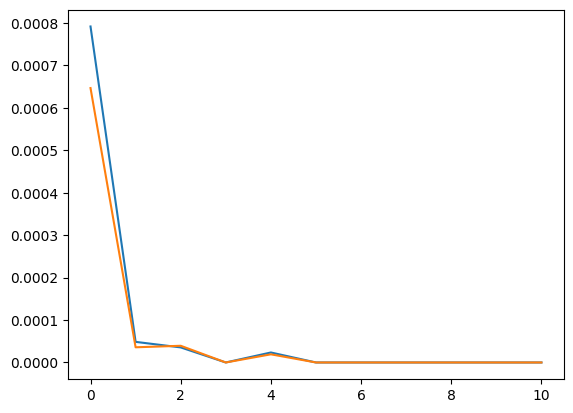

In [15]:
plt.plot(DD)
plt.plot(RR)

C:\Users\andre\AppData\Local\Temp\ipykernel_48352\3301906541.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(DD/RR-1)


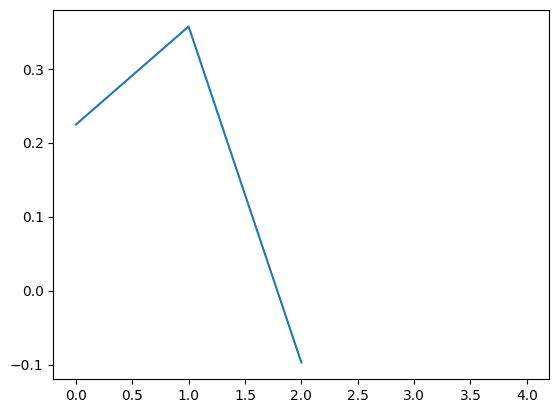

In [16]:
plt.plot(DD/RR-1)

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord

df_rand = pd.read_csv(rand_path+'.csv')
df_Cos_3D = pd.read_csv('For_YAW/C3D_Candidates_v2_Christa_F115W.csv')



In [18]:
import Koki_help.HSC_toolkits as HSC
hsc = HSC.HSC_toolkits()

In [19]:
import pickle
with open("For_YAW/ref_galaxy_bins.pkl", "rb") as f:
    ref_galaxy_bins = pickle.load(f)

In [20]:
random = {}
random['SkyCoord'] = SkyCoord(df_rand['ra'], df_rand['dec'], unit=(u.deg, u.deg), frame='icrs')
reference_bins = {}
for key in ref_galaxy_bins:
    reference_bins[key] = {'SkyCoord': SkyCoord(ref_galaxy_bins[key]['ra'], ref_galaxy_bins[key]['dec'], unit=(u.deg, u.deg), frame='icrs')}

small_ref = {}
small_ref['SkyCoord'] = SkyCoord(df_Web_unkn['ra'], df_Web_unkn['dec'], unit=(u.deg, u.deg), frame='icrs')

cosmos_3D = {}
cosmos_3D['SkyCoord'] = SkyCoord(df_Cos_3D['RA'], df_Cos_3D['Dec'], unit=(u.deg, u.deg), frame='icrs')


In [21]:
df_Cos_3D

,Confidence,Link,RA,Dec,Host_ID,Host_RA,Host_Dec,Host_sep,Host_z,Host_z_final,needs_further_inspection,Christa_Comment
0,2,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.759004,2.133165,216141,149.758999,2.133157,0.032,2.203,-99.000,yes,hostless? Weird shape
1,3,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.767877,2.119591,214949,149.767867,2.119588,0.038,1.340,-99.000,yes,seems real? Or something weird going on with s...
2,3,https://www.stsci.edu/~tsst/c3d/o001_t001_0_co...,149.782602,2.095719,212206,149.782602,2.095726,0.025,1.350,-99.000,yes,seems like something weird going on with subtr...
3,2,https://www.stsci.edu/~tsst/c3d/o004_t004_3_co...,150.234389,1.886099,326840,150.234485,1.886024,0.441,0.006,0.006,yes,maybe real?
4,2,https://www.stsci.edu/~tsst/c3d/o004_t004_3_co...,150.258403,1.938228,334460,150.258400,1.938082,0.526,0.679,-99.000,yes,maybe real?
...,...,...,...,...,...,...,...,...,...,...,...,...
137,2,https://www.stsci.edu/~tsst/c3d/o016_t016_2_co...,150.345925,2.261992,726201,150.345927,2.261987,0.018,1.768,1.768,yes,seems real; nuclear transient?
138,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.373547,2.224541,763665,150.373569,2.224527,0.095,0.979,0.979,NaN,real
139,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.389550,2.255718,767926,150.389512,2.255856,0.517,1.310,-99.000,NaN,real
140,1,https://www.stsci.edu/~tsst/c3d/o016_t016_3_co...,150.370572,2.189248,779047,150.370581,2.189255,0.042,0.730,0.730,NaN,real


In [22]:
len(cosmos_3D['SkyCoord'])

142

In [23]:
len(small_ref['SkyCoord'])

1000

In [24]:
len(random['SkyCoord'])

10000

In [25]:
len(reference_bins['0.0-1.0']['SkyCoord'])

356999

In [26]:
bins=10
min_bin=10**-4*u.deg #1*u.arcmin
max_bin=10**-1*u.deg
bin_type='log-bin'

Omega_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_Web={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_Web['ACF_LS'], Error_Web['ACF_LS'], theta_Web['ACF_LS']= \
        hsc.Landy_Szalay_estimator(small_ref['SkyCoord'],random['SkyCoord'],    #cosmos_Web['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type)




Omega_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
Error_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}
theta_3D={'ACF_LS': [], 'CCF_LS': {}, 'CCF_DP': {}}

Omega_3D['ACF_LS'], Error_3D['ACF_LS'], theta_3D['ACF_LS']= \
        hsc.Landy_Szalay_estimator(cosmos_3D['SkyCoord'],random['SkyCoord'],    #cosmos_3D['SkyCoord']
                                   min_bin=min_bin, max_bin=max_bin,
                                   bins=bins, type=bin_type)




# Omega['CCF'], Error['CCF'], theta['CCF']= \
#         hsc.Landy_Szalay_estimator_cross(
# #                                fg_data_objects, bg_data_objects,
#                                 small_ref['SkyCoord'],reference_bins['0.0-1.0']['SkyCoord'],
#                                 random['SkyCoord'], random['SkyCoord'],
#                                 min_bin=min_bin, max_bin=max_bin,
#                                 bins=bins, type=bin_type)

Computing data-data pair counts ...
Computing data-random pair counts ...
Computing random-random pair counts ...


c:\Users\andre\MasterCode\Code\Koki_help\HSC_toolkits.py:928: RuntimeWarning: divide by zero encountered in divide
  ERROR = 1/np.sqrt(DD)


Computing data-data pair counts ...
Computing data-random pair counts ...
Computing random-random pair counts ...


Text(0.5, 0, ' θ [deg]')

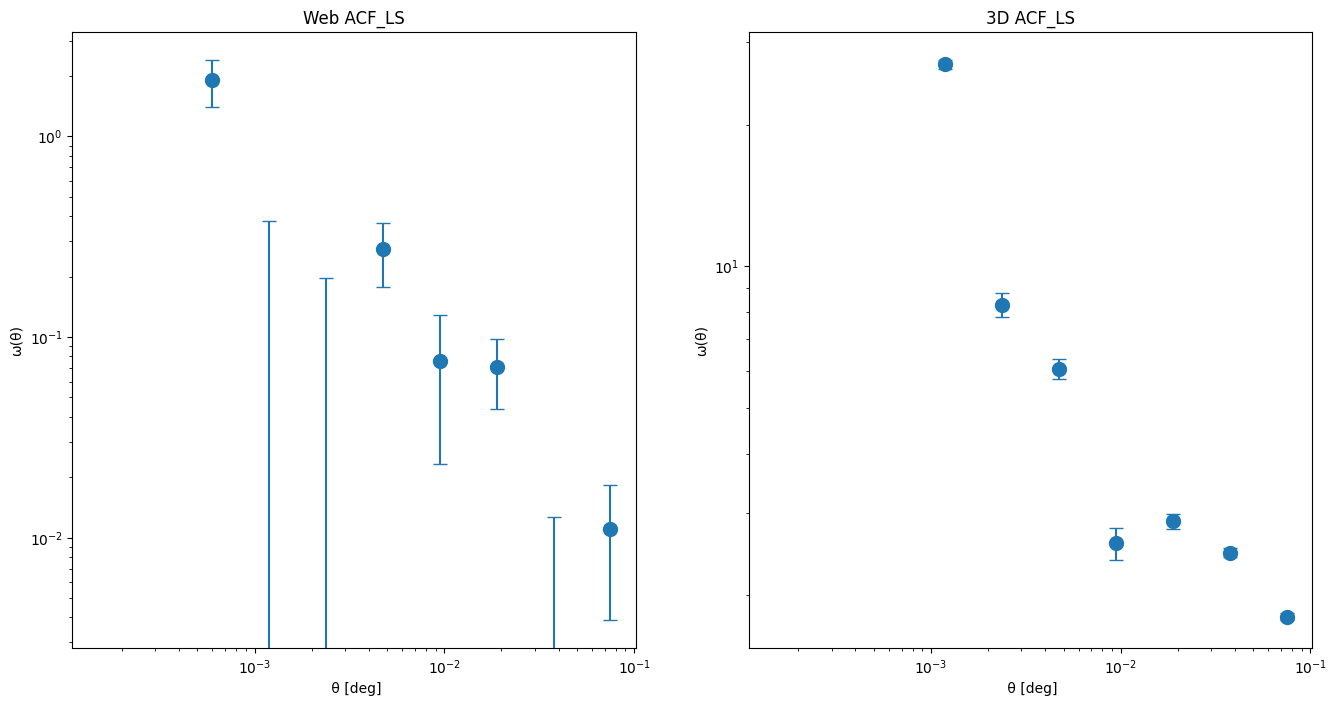

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web ACF_LS')
plt.errorbar(theta_Web['ACF_LS'].to('deg').value,Omega_Web['ACF_LS'], yerr = Error_Web['ACF_LS'], fmt='o', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')

plt.subplot(1,2,2)
plt.title('3D ACF_LS')
plt.errorbar(theta_3D['ACF_LS'].to('deg').value,Omega_3D['ACF_LS'], yerr = Error_3D['ACF_LS'], fmt='o', ms=10, capsize=5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('\u03C9(\u03B8)')
plt.xlabel(' \u03B8 [deg]')
#plt.plot(theta['ACF'].to('arcsec').value,Omega['ACF']+1/N_LAE,yerr=sqrt(Var_JK['ACF']),fmt='s',ms=10,capsize=5)

In [28]:
z_bins= ['0.0-1.0', '1.0-2.0' , '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0']
for z in z_bins:
    Omega_Web['CCF_LS'][z], Error_Web['CCF_LS'][z], theta_Web['CCF_LS'][z] = \
        hsc.Landy_Szalay_estimator_cross(
                                small_ref['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random['SkyCoord'], random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    

    Omega_3D['CCF_LS'][z], Error_3D['CCF_LS'][z], theta_3D['CCF_LS'][z] = \
        hsc.Landy_Szalay_estimator_cross(
                                cosmos_3D['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random['SkyCoord'], random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)

Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Co

c:\Users\andre\MasterCode\Code\Koki_help\HSC_toolkits.py:1022: RuntimeWarning: divide by zero encountered in divide
  ERROR = 1 / np.sqrt(D1D2 * N_data_1 * N_data_2)


Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...
Computing data1-data2 pair counts ...
Computing data1-random2 pair counts ...
Computing data2-random1 pair counts ...
Computing random1-random2 pair counts ...


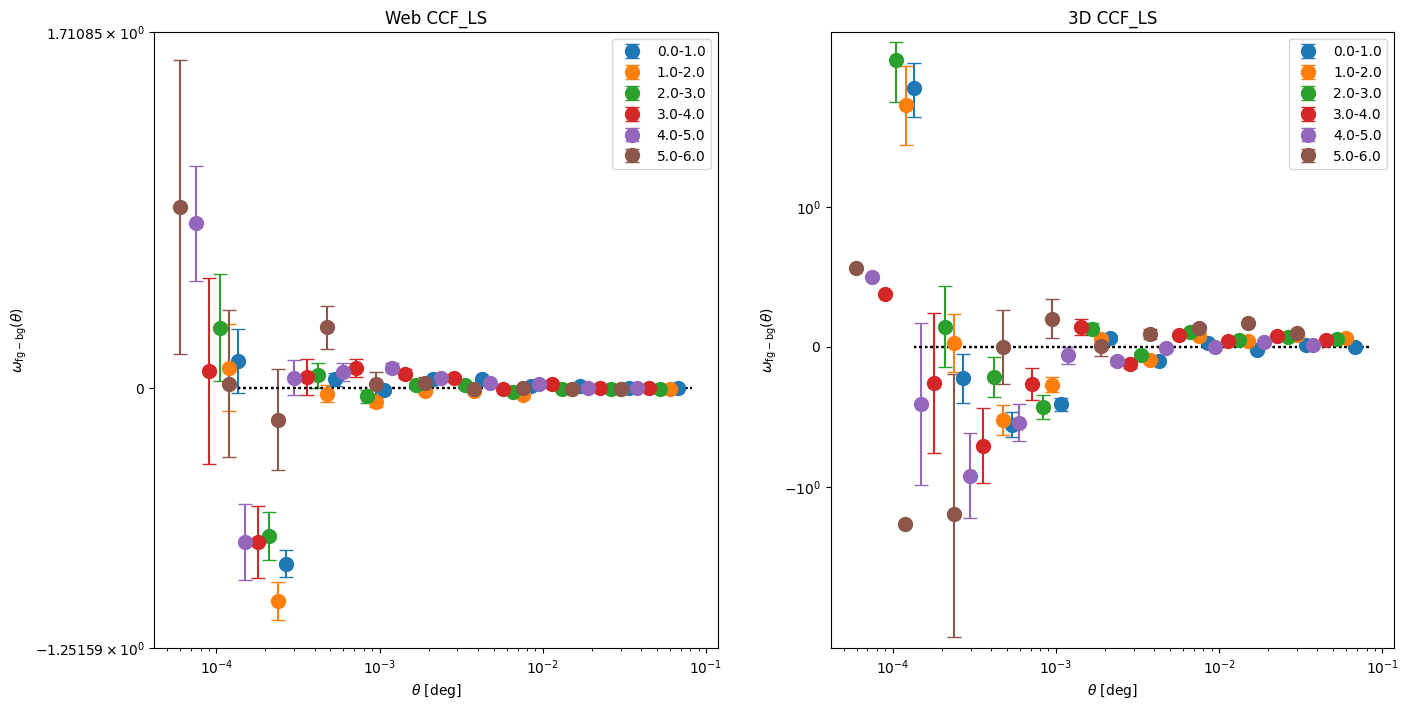

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_LS')
sep = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_Web['CCF_LS'][z].to('deg').value*sep[i], Omega_Web['CCF_LS'][z],
            yerr=Error_Web['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
    plt.hlines(0.0, 0.9*theta_Web['CCF_LS'][z].min().to('deg').value,
                1.1*theta_Web['CCF_LS'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_LS')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.errorbar(theta_3D['CCF_LS'][z].to('deg').value*sep[i], Omega_3D['CCF_LS'][z],
            yerr=Error_3D['CCF_LS'][z], fmt='o', ms=10,capsize=5, label=z)

    
    plt.hlines(0.0, 0.9*theta_3D['CCF_LS'][z].min().to('deg').value,
                1.1*theta_3D['CCF_LS'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

In [30]:
z_bins= ['0.0-1.0', '1.0-2.0' , '2.0-3.0', '3.0-4.0', '4.0-5.0', '5.0-6.0']
for z in z_bins:
    Omega_Web['CCF_DP'][z], theta_Web['CCF_DP'][z] = \
        hsc.Davis_Peebles_estimator_cross(                                                  #, Error_Web['CCF_DP'][z]
                                small_ref['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_Web['SkyCoord']
                                random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)
    
for z in z_bins:
    Omega_3D['CCF_DP'][z], theta_3D['CCF_DP'][z] = \
        hsc.Davis_Peebles_estimator_cross(                                                  #, Error_3D['CCF_DP'][z]                      
                                cosmos_3D['SkyCoord'], reference_bins[z]['SkyCoord'],    #small_ref['SkyCoord']cosmos_3D['SkyCoord']
                                random['SkyCoord'],
                                min_bin=min_bin, max_bin=max_bin,
                                bins=bins, type=bin_type)

Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...
Computing data1 – data2 pair counts ...
Computing data2 – random1 pair counts ...


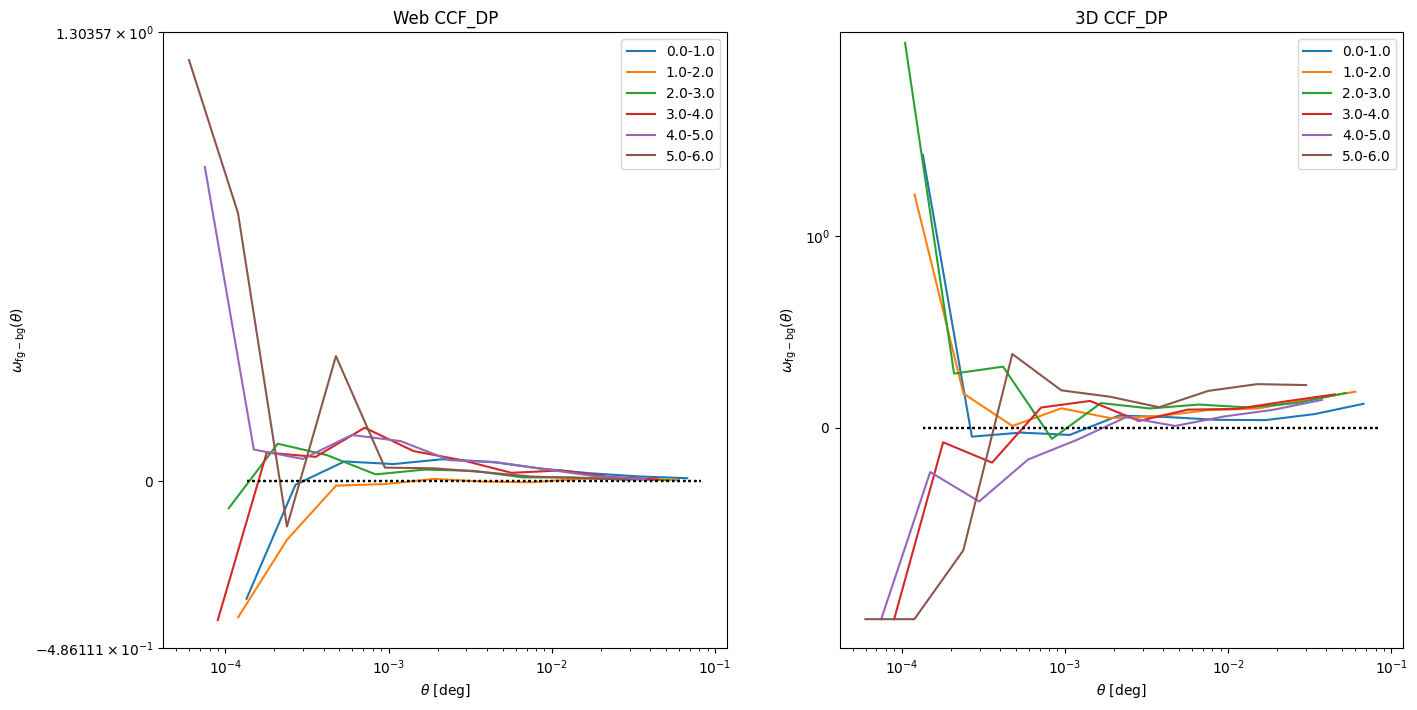

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Web CCF_DP')
sep = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.plot(theta_Web['CCF_DP'][z].to('deg').value*sep[i], Omega_Web['CCF_DP'][z],label=z)
    plt.hlines(0.0, 0.9*theta_Web['CCF_DP'][z].min().to('deg').value,
                1.1*theta_Web['CCF_DP'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

plt.subplot(1,2,2)
plt.title('3D CCF_DP')
for i in range(len(z_bins)):
    z=z_bins[i]
    plt.plot(theta_3D['CCF_DP'][z].to('deg').value*sep[i], Omega_3D['CCF_DP'][z], label=z)

    
    plt.hlines(0.0, 0.9*theta_3D['CCF_DP'][z].min().to('deg').value,
                1.1*theta_3D['CCF_DP'][z].max().to('deg').value,
                linestyle='dotted',color='black')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$\\omega_{\\rm fg-bg}(\\theta)$')
plt.legend()

In [76]:
Omega_Web['CCF_DP']['2.0-3.0']

array([-0.0797546 ,  0.107739  ,  0.07490637,  0.01868538,  0.03255063,
        0.02906365,  0.01006619,  0.00959078,  0.00499599,  0.00163664])

In [40]:
angles = theta_Web['CCF_DP']['0.0-1.0'].to('deg').value

In [43]:
len(theta_Web['CCF_DP']['0.0-1.0'].to('deg').value)

10

In [103]:
values_web_DP = []
values_web_LS = []
for angle in range(len(angles)):
    value_web_DP = []
    value_web_LS = []
    for z in z_bins:
        value_web_DP.append(Omega_Web['CCF_DP'][z][angle])
        value_web_LS.append(Omega_Web['CCF_LS'][z][angle])
        
    values_web_DP.append(value_web_DP)
    values_web_LS.append(value_web_DP)


values_3D_DP = []
values_3D_LS = []
for angle in range(len(angles)):
    value_3D_DP = []
    value_3D_LS = []
    for z in z_bins:
        value_3D_DP.append(Omega_3D['CCF_DP'][z][angle])
        value_3D_LS.append(Omega_3D['CCF_LS'][z][angle])
        
    values_3D_DP.append(value_3D_DP)
    values_3D_LS.append(value_3D_DP)

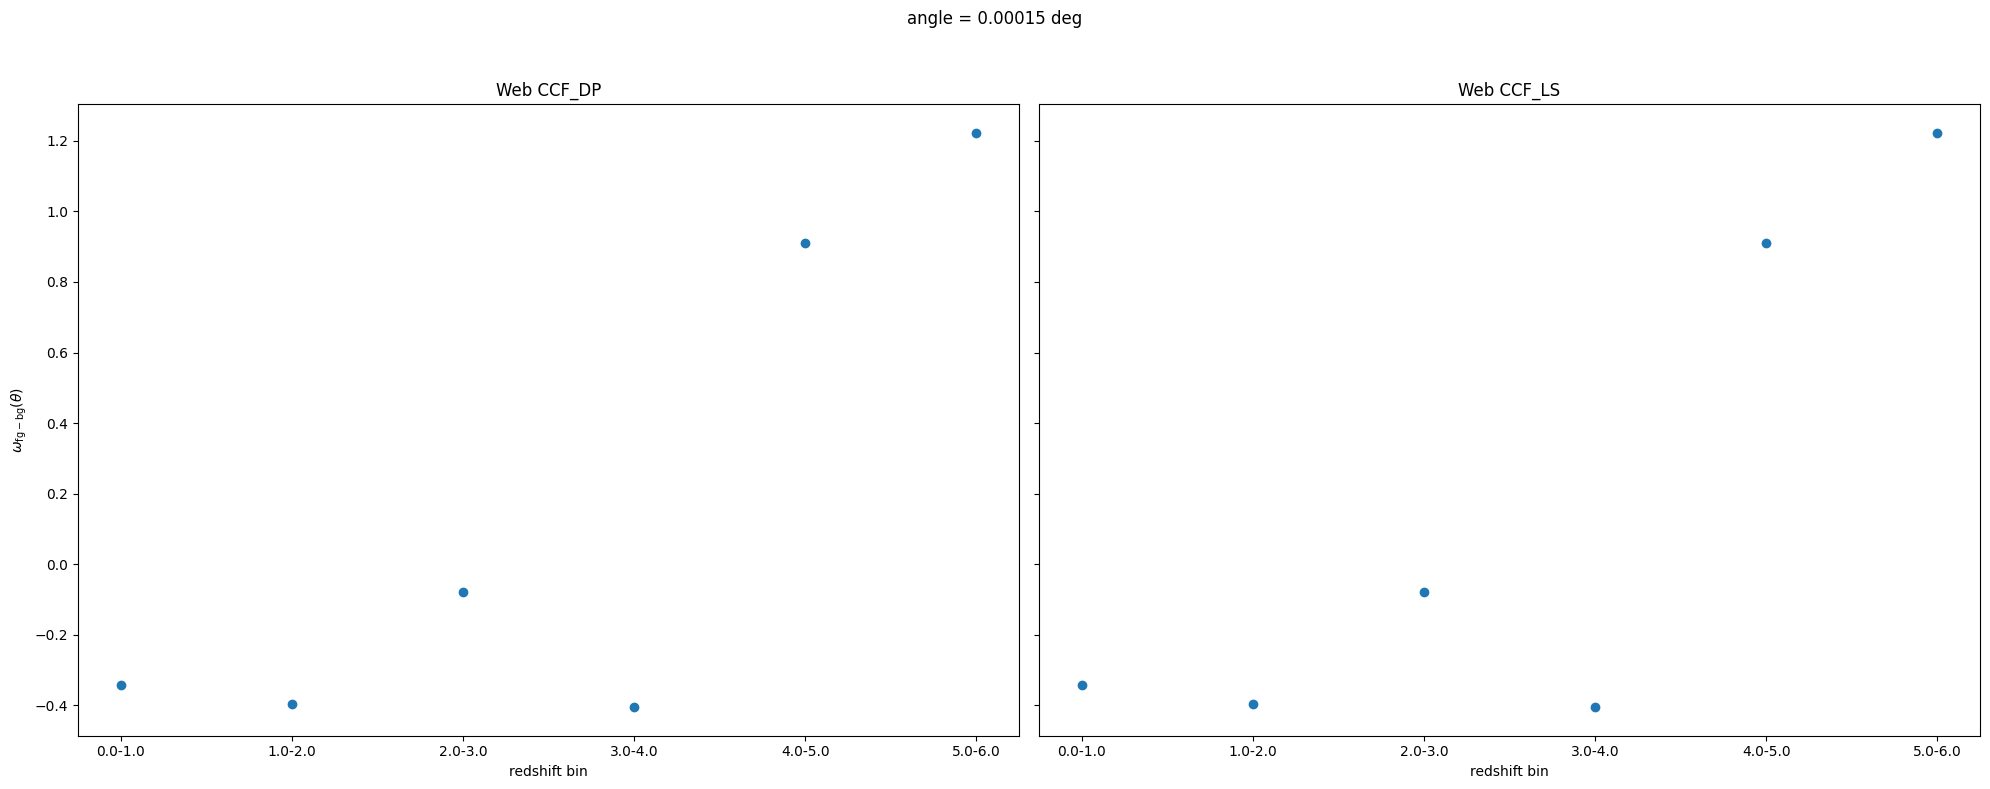

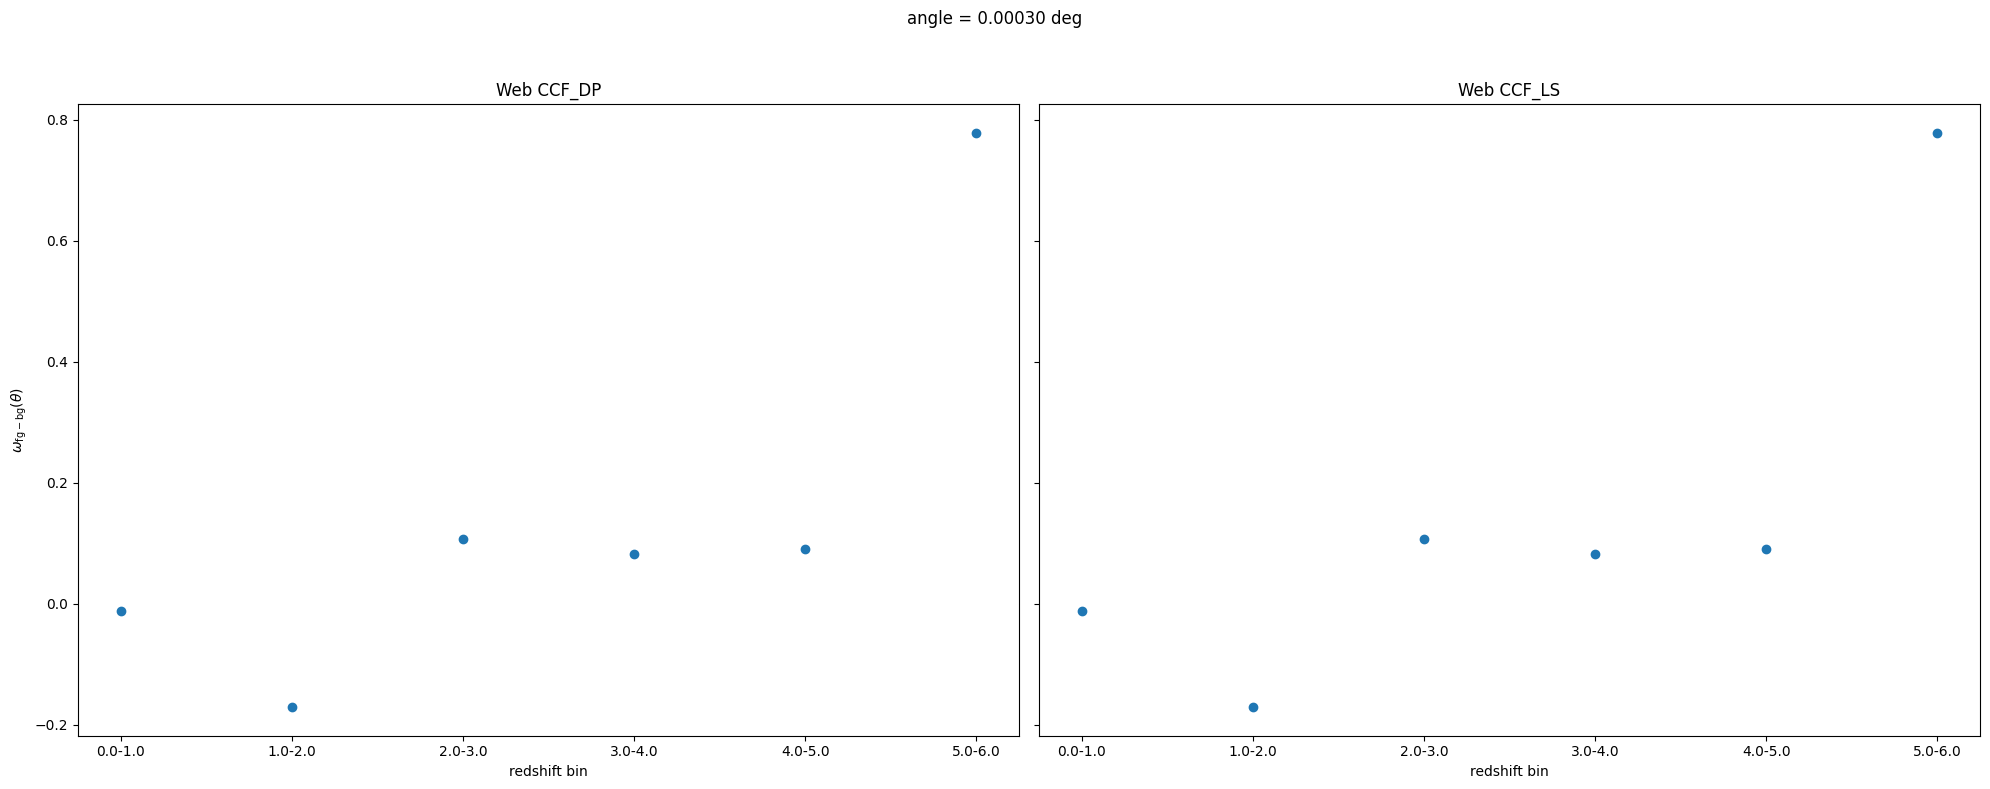

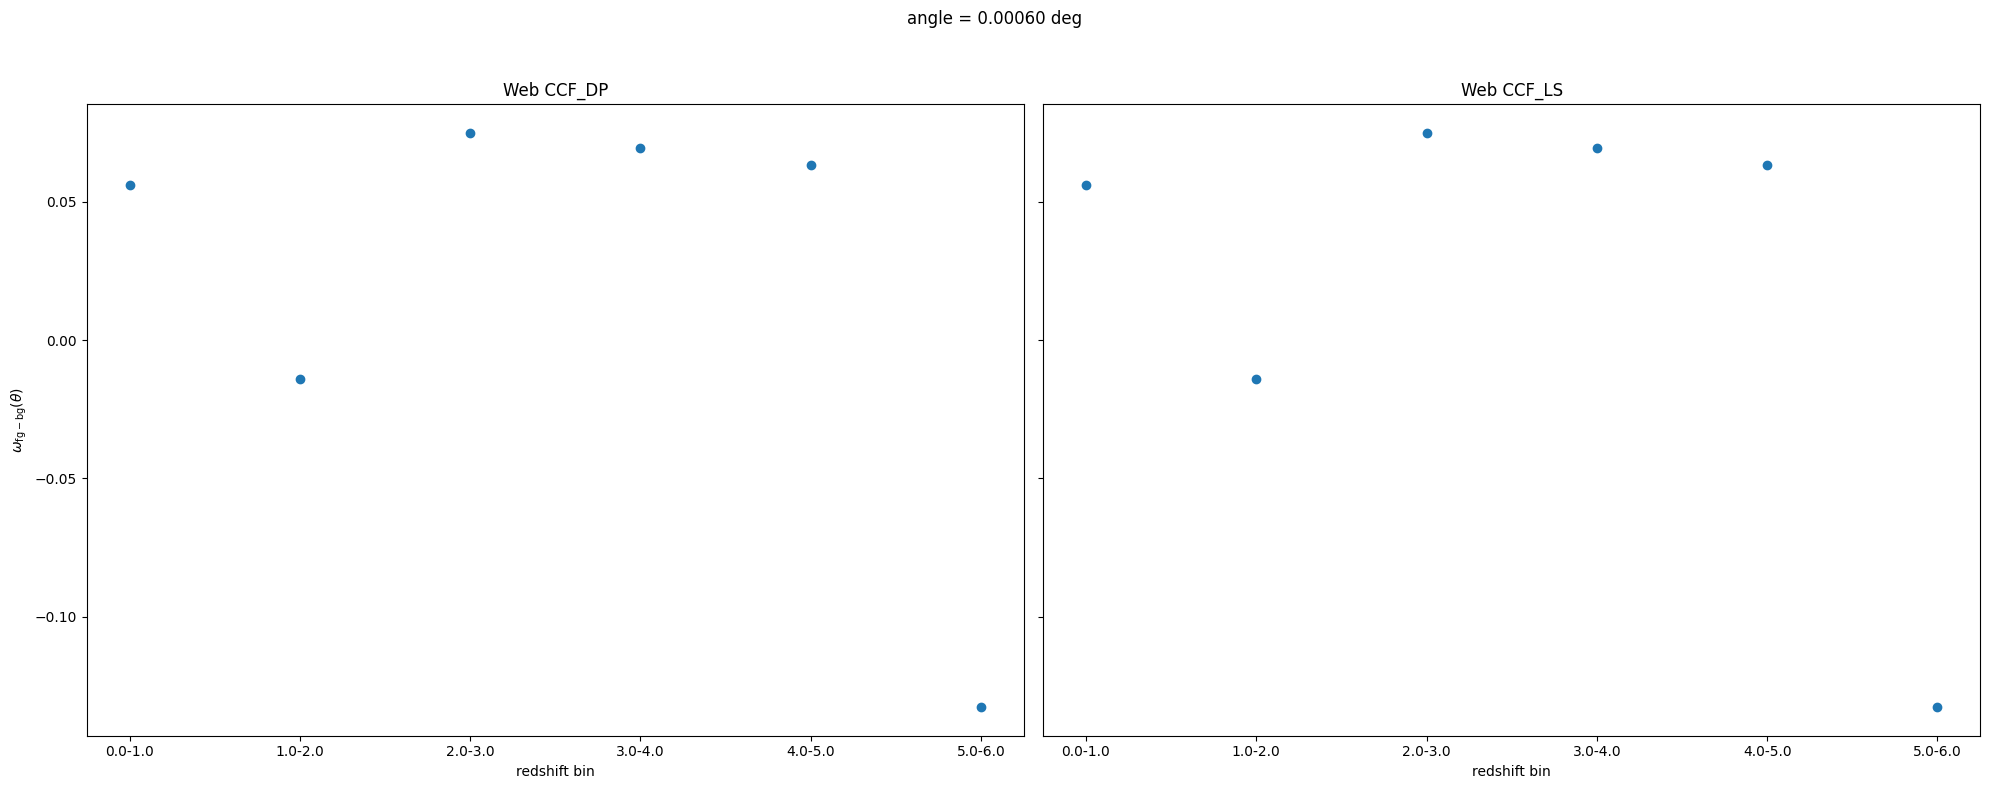

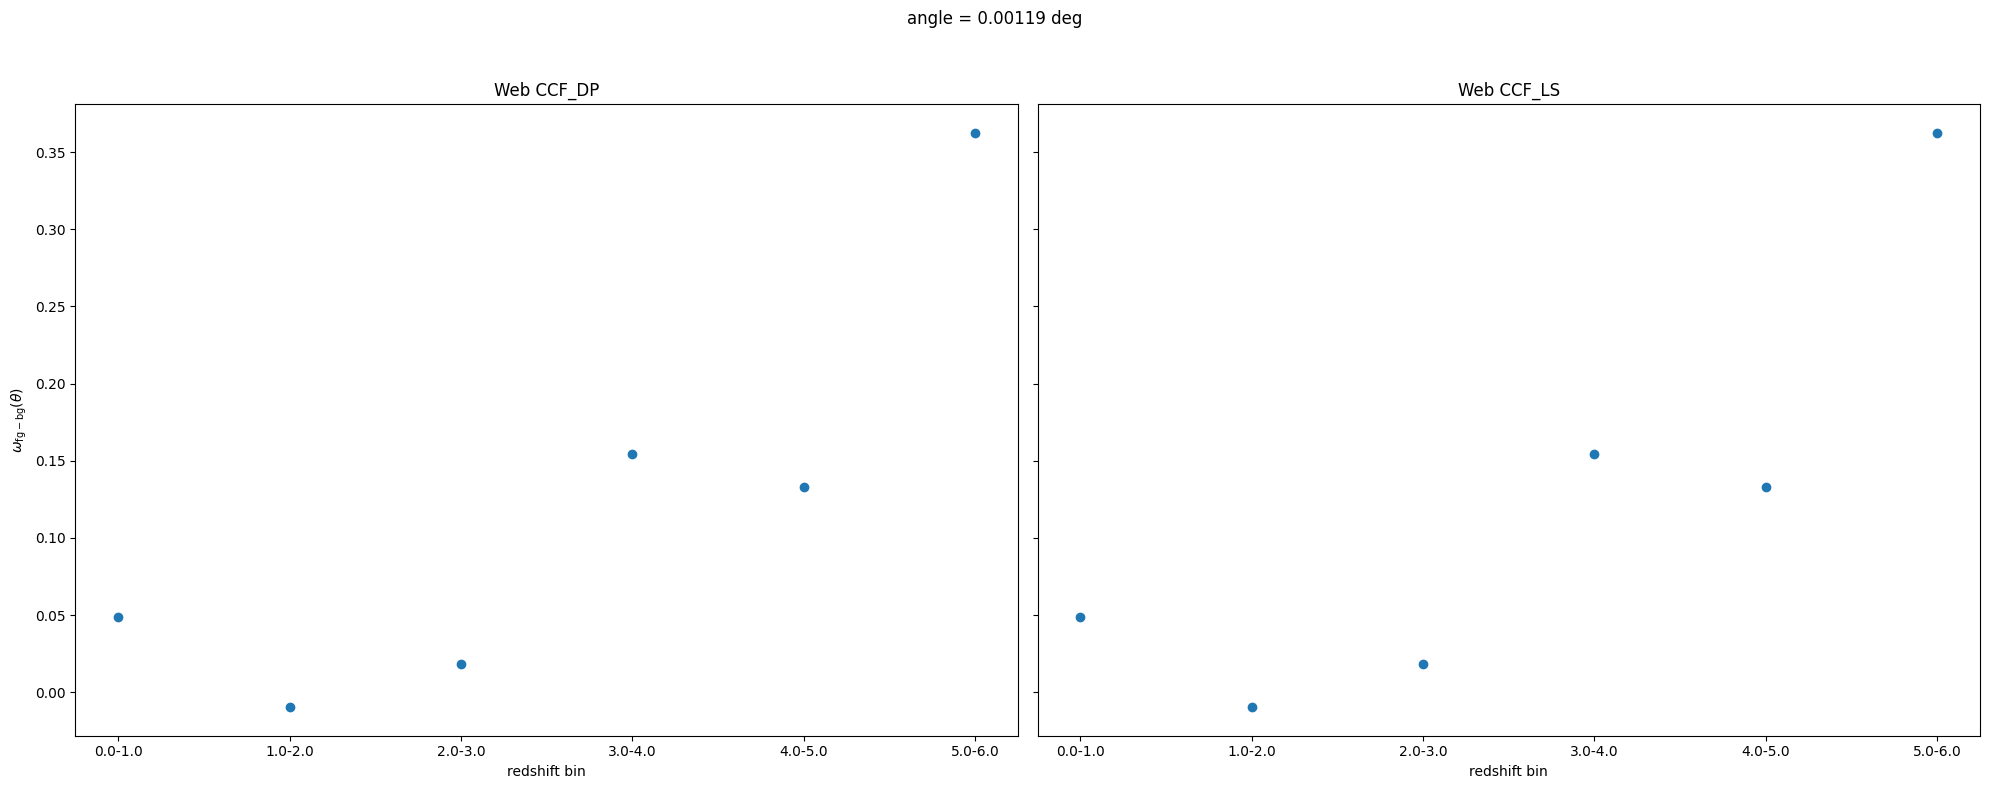

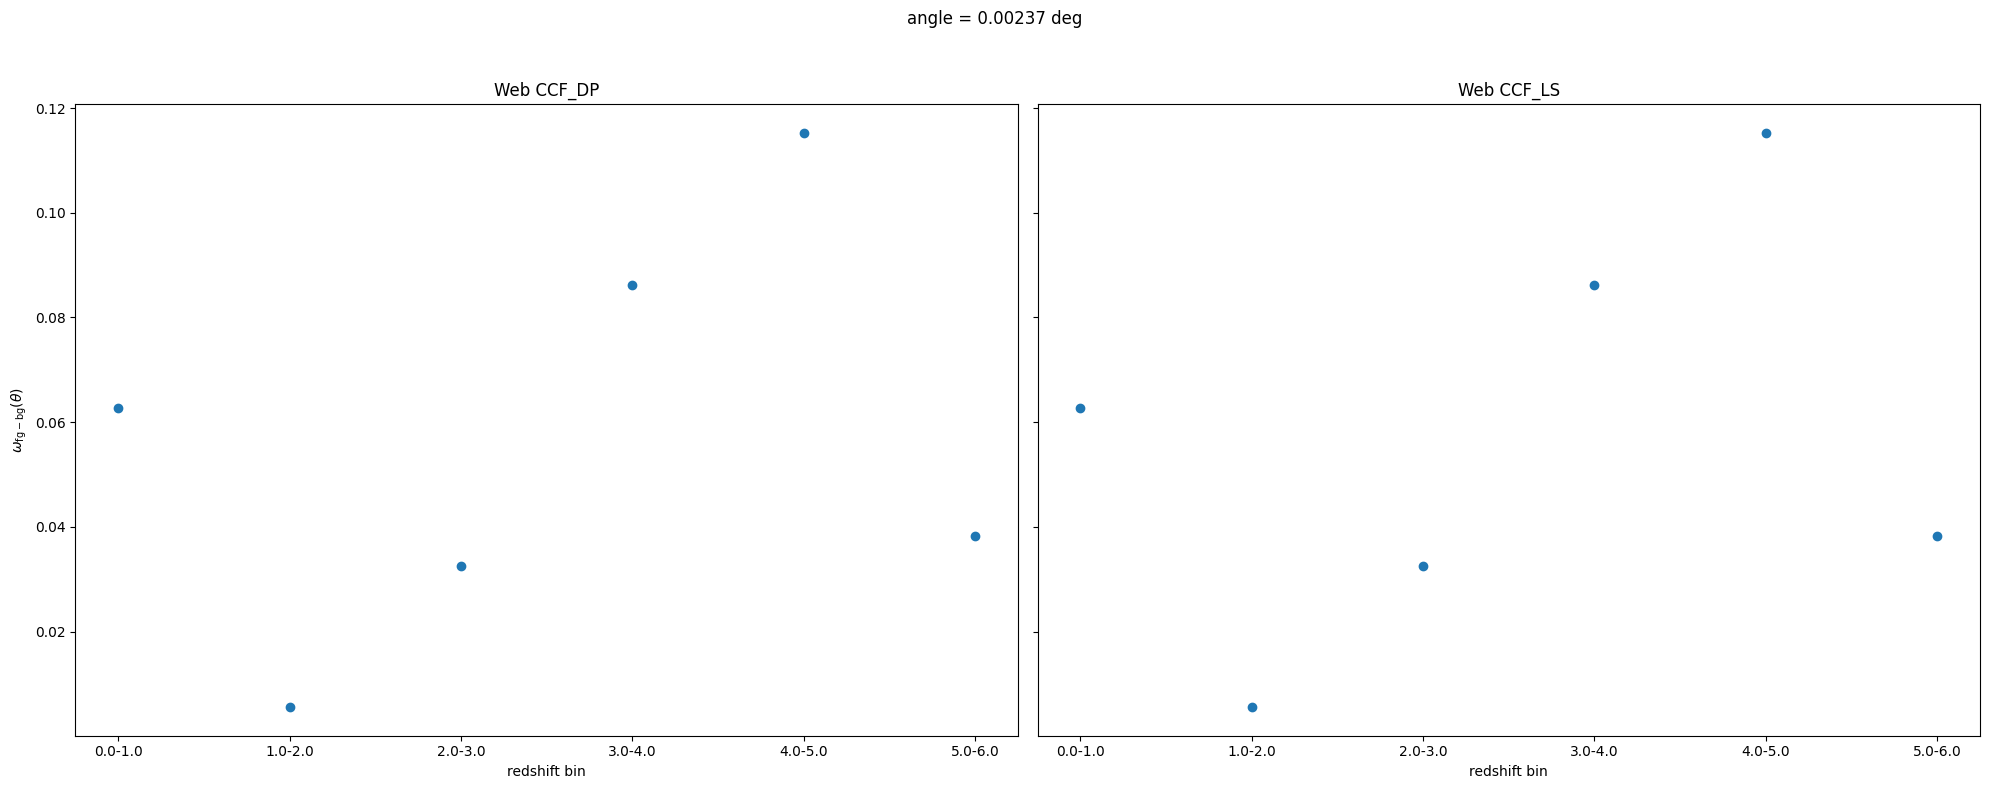

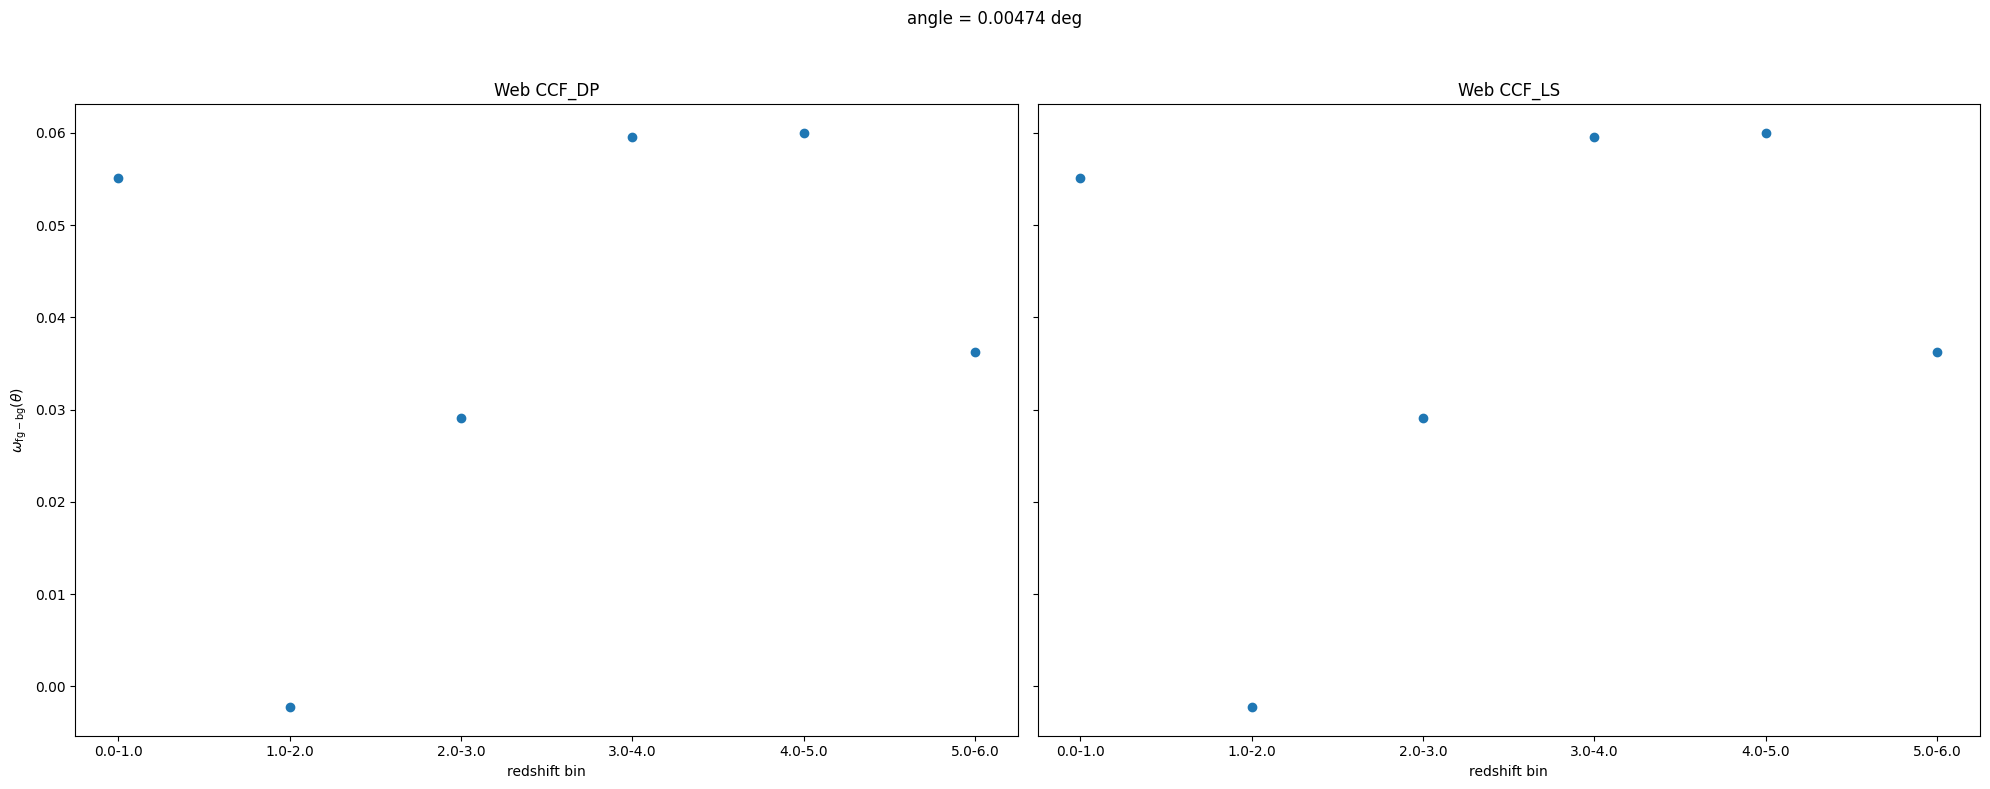

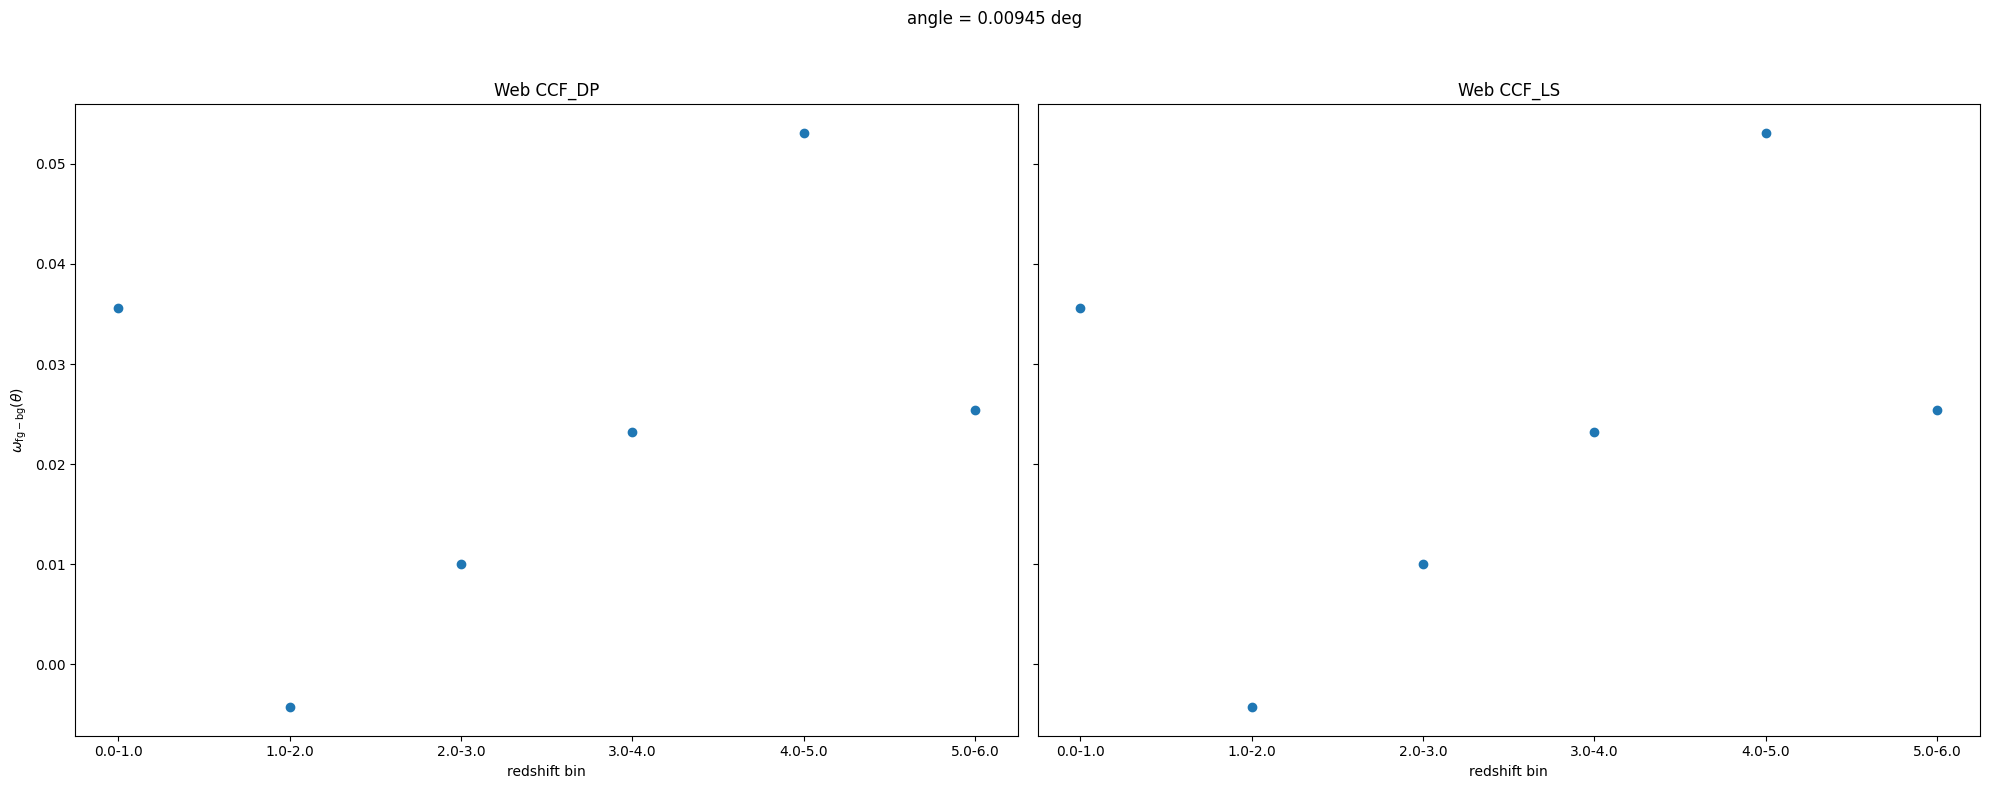

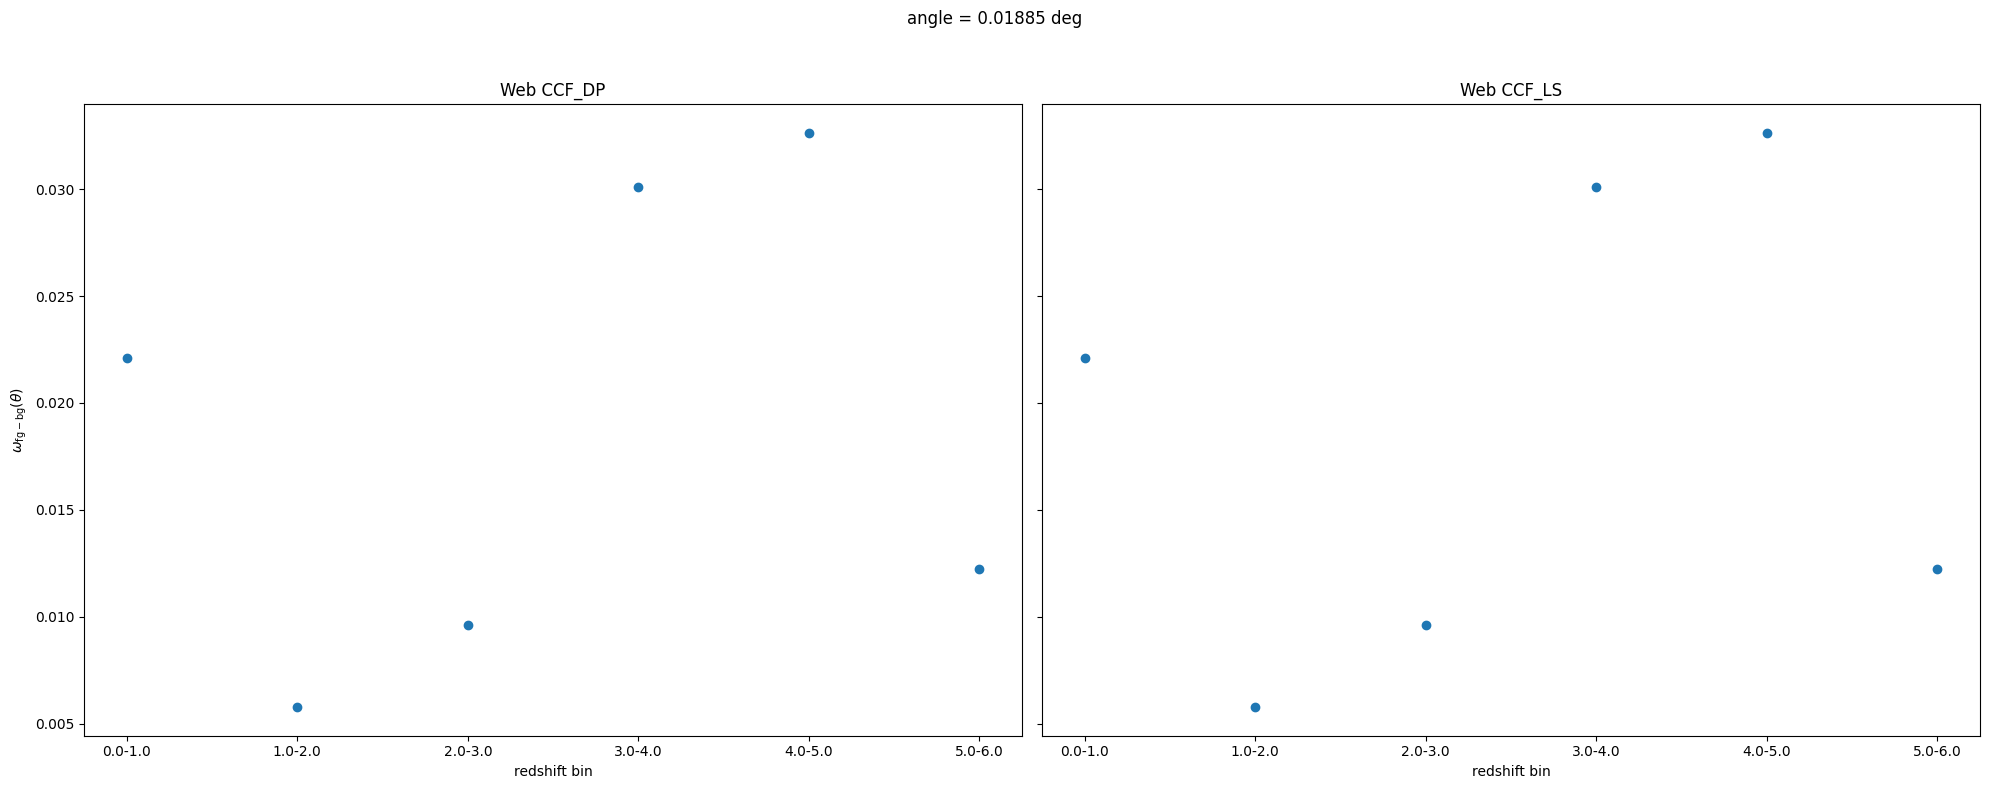

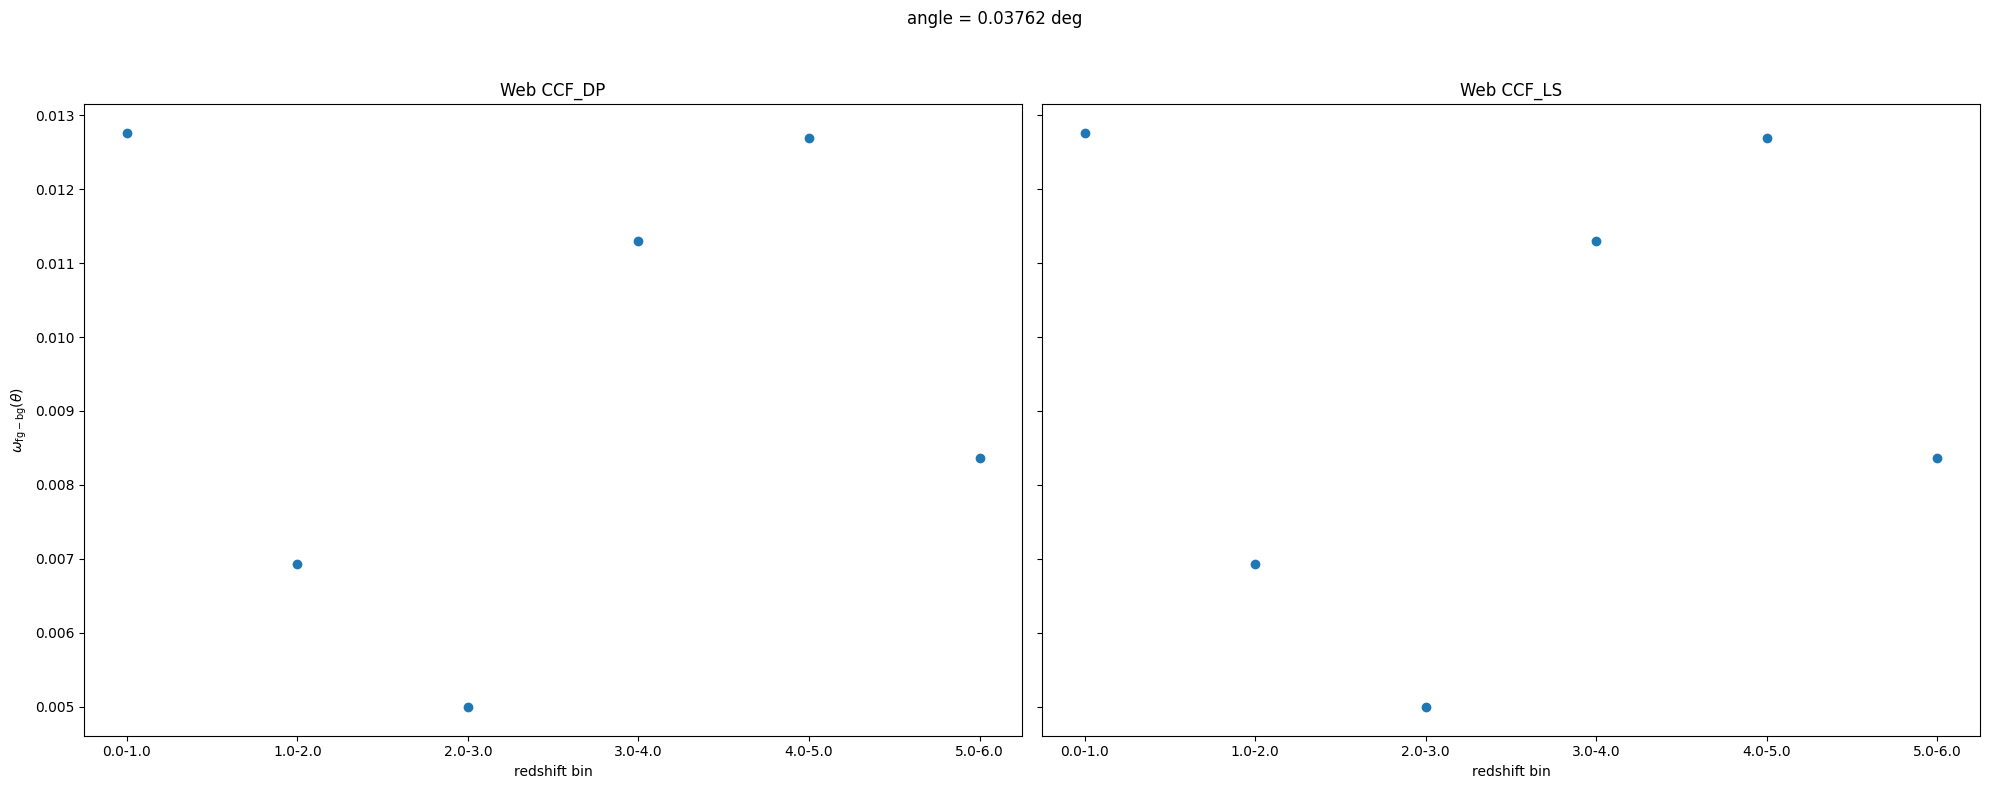

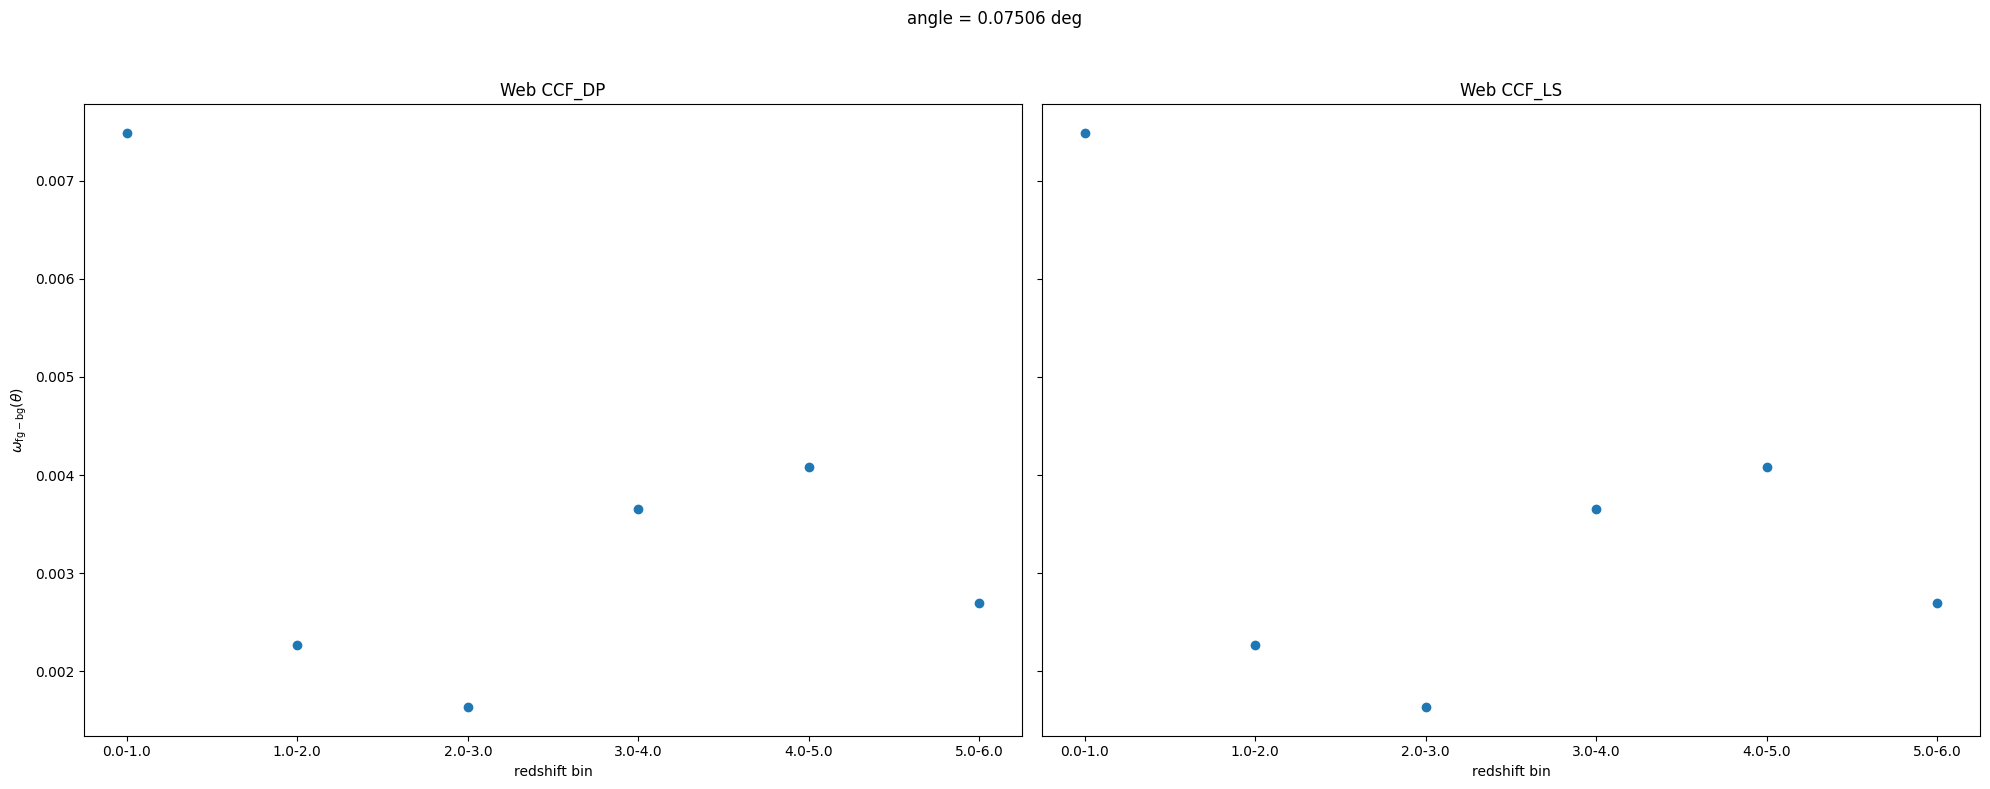

In [101]:
for j in range(len(values_web_DP)):
    fig, axes = plt.subplots(1, 2, figsize=(20,8), sharey=True)
    fig.suptitle(f'angle = {angles[j]:.5f} deg')

    axes[0].set_title('Web CCF_DP')
    axes[0].set_xlabel('redshift bin')
    axes[0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[0].scatter(z_bins, values_web_DP[j])

    axes[1].set_title('Web CCF_LS')
    axes[1].set_xlabel('redshift bin')
    axes[1].scatter(z_bins, values_web_LS[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

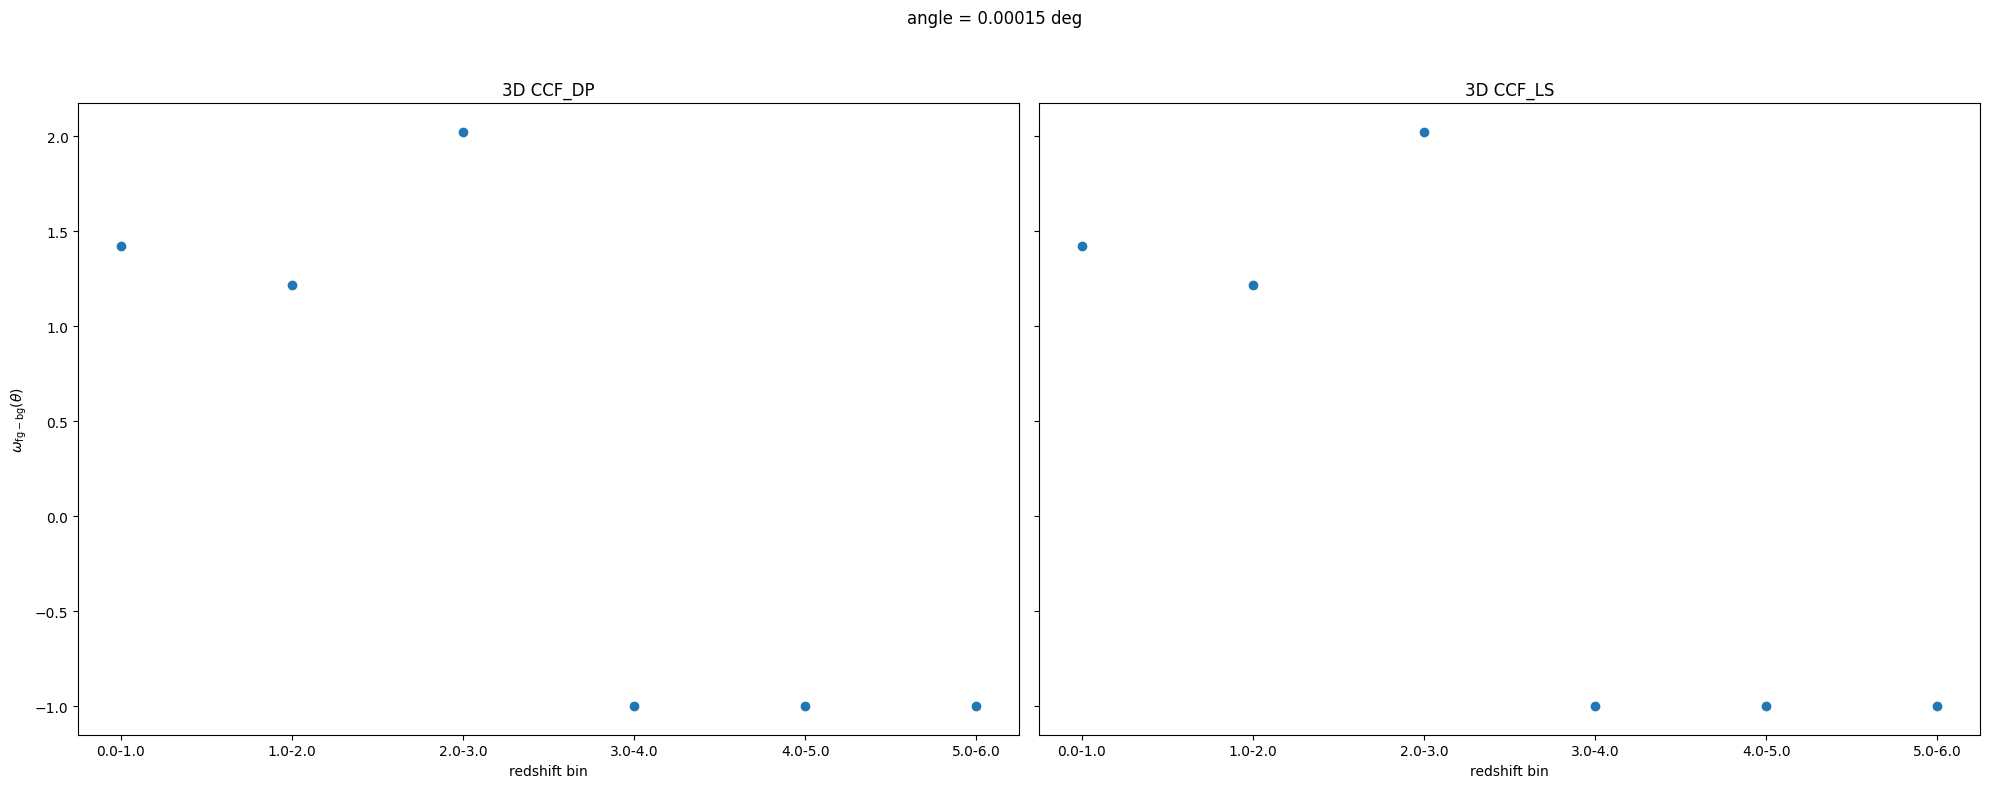

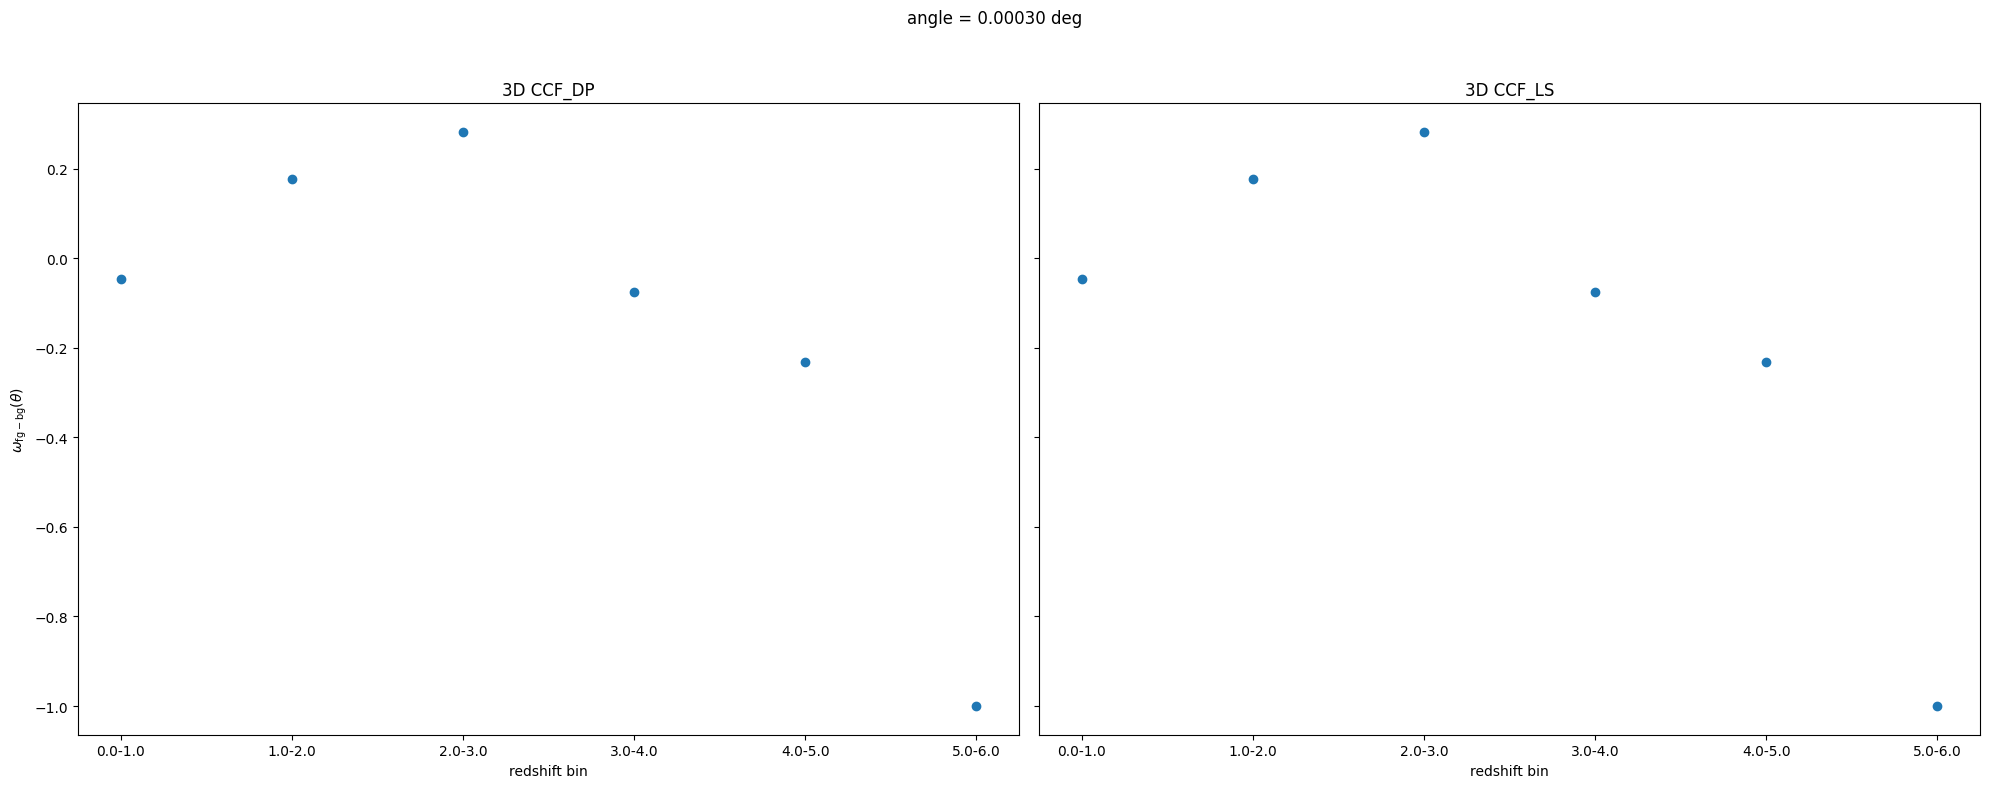

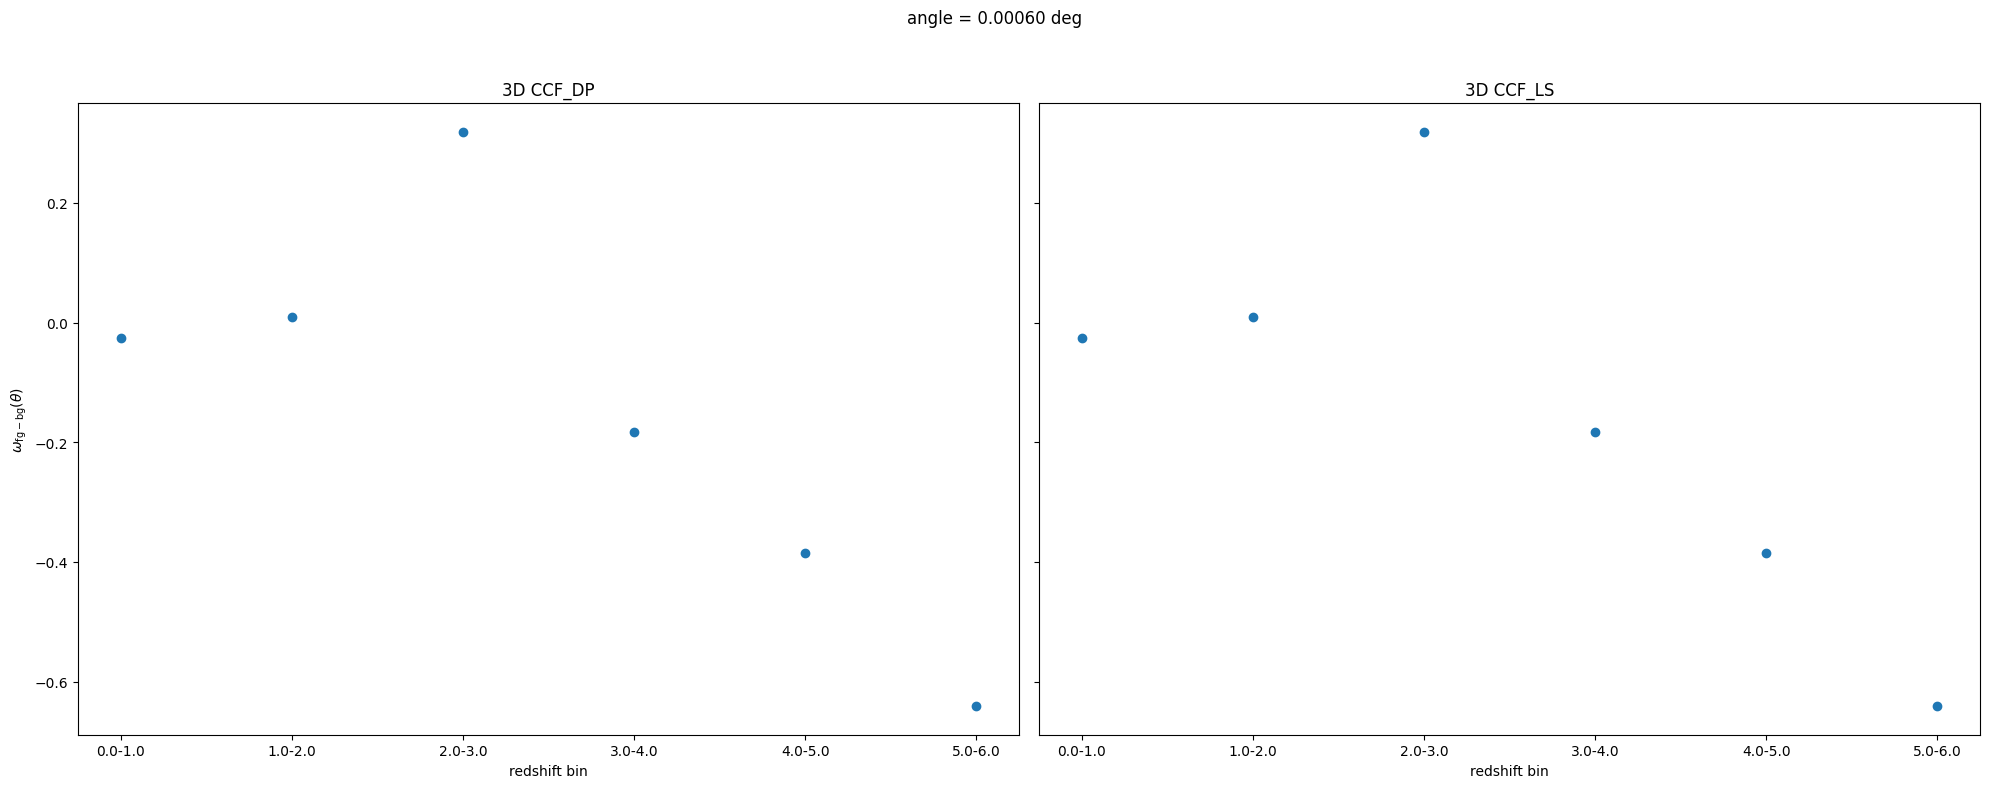

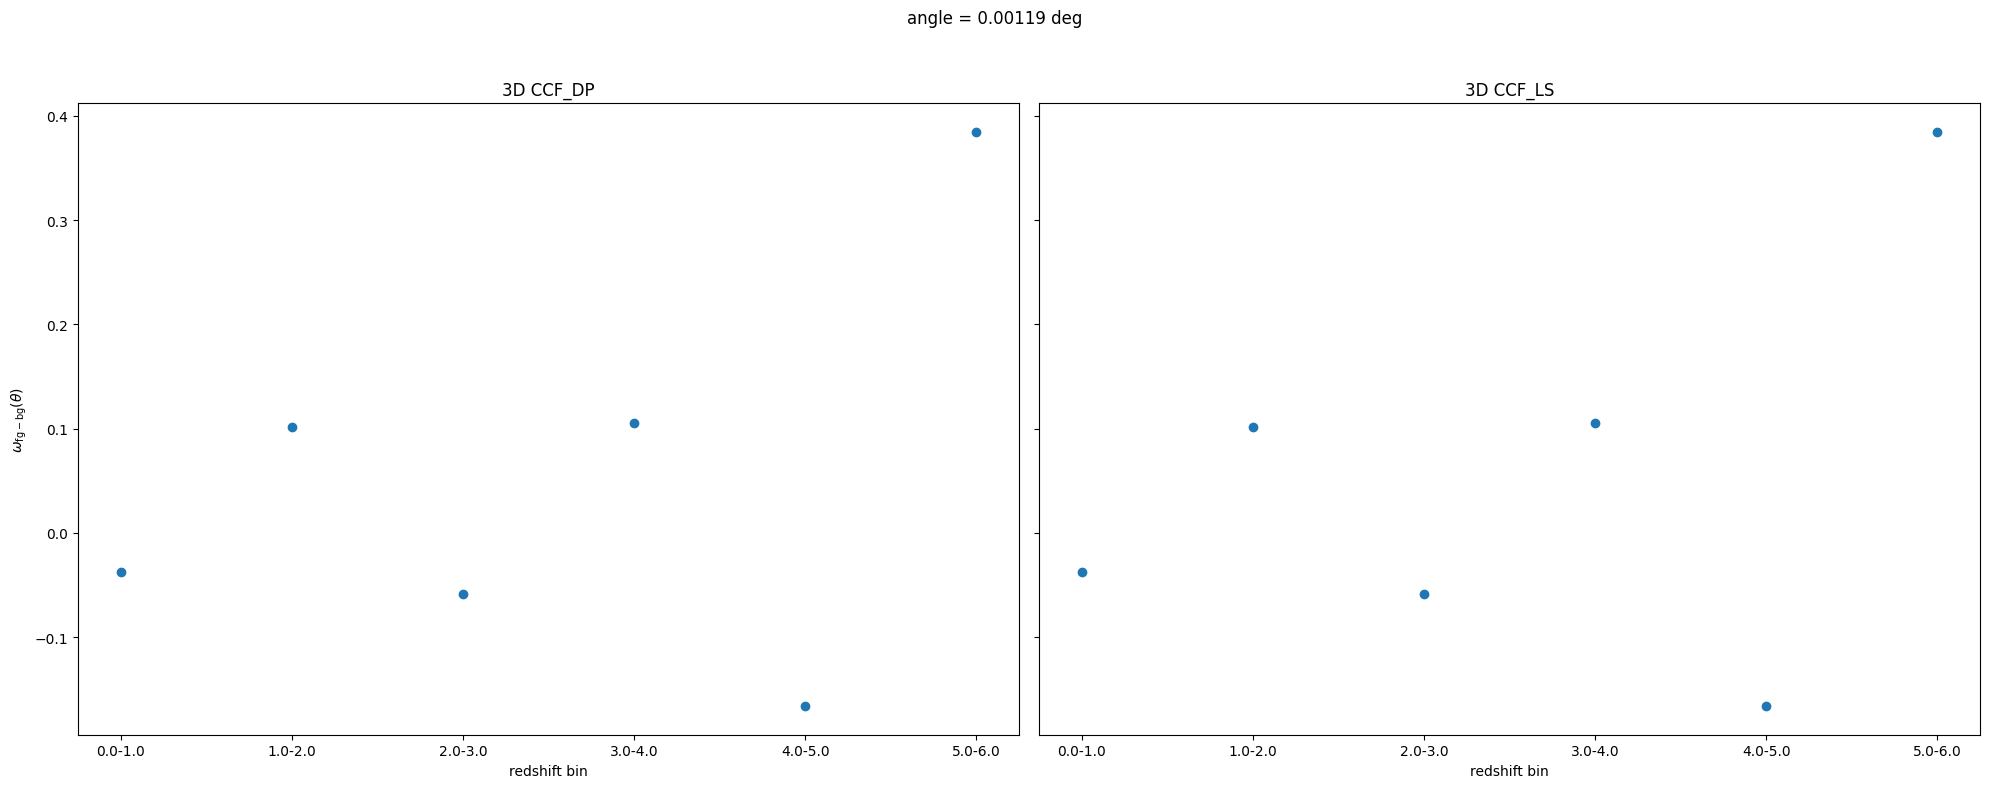

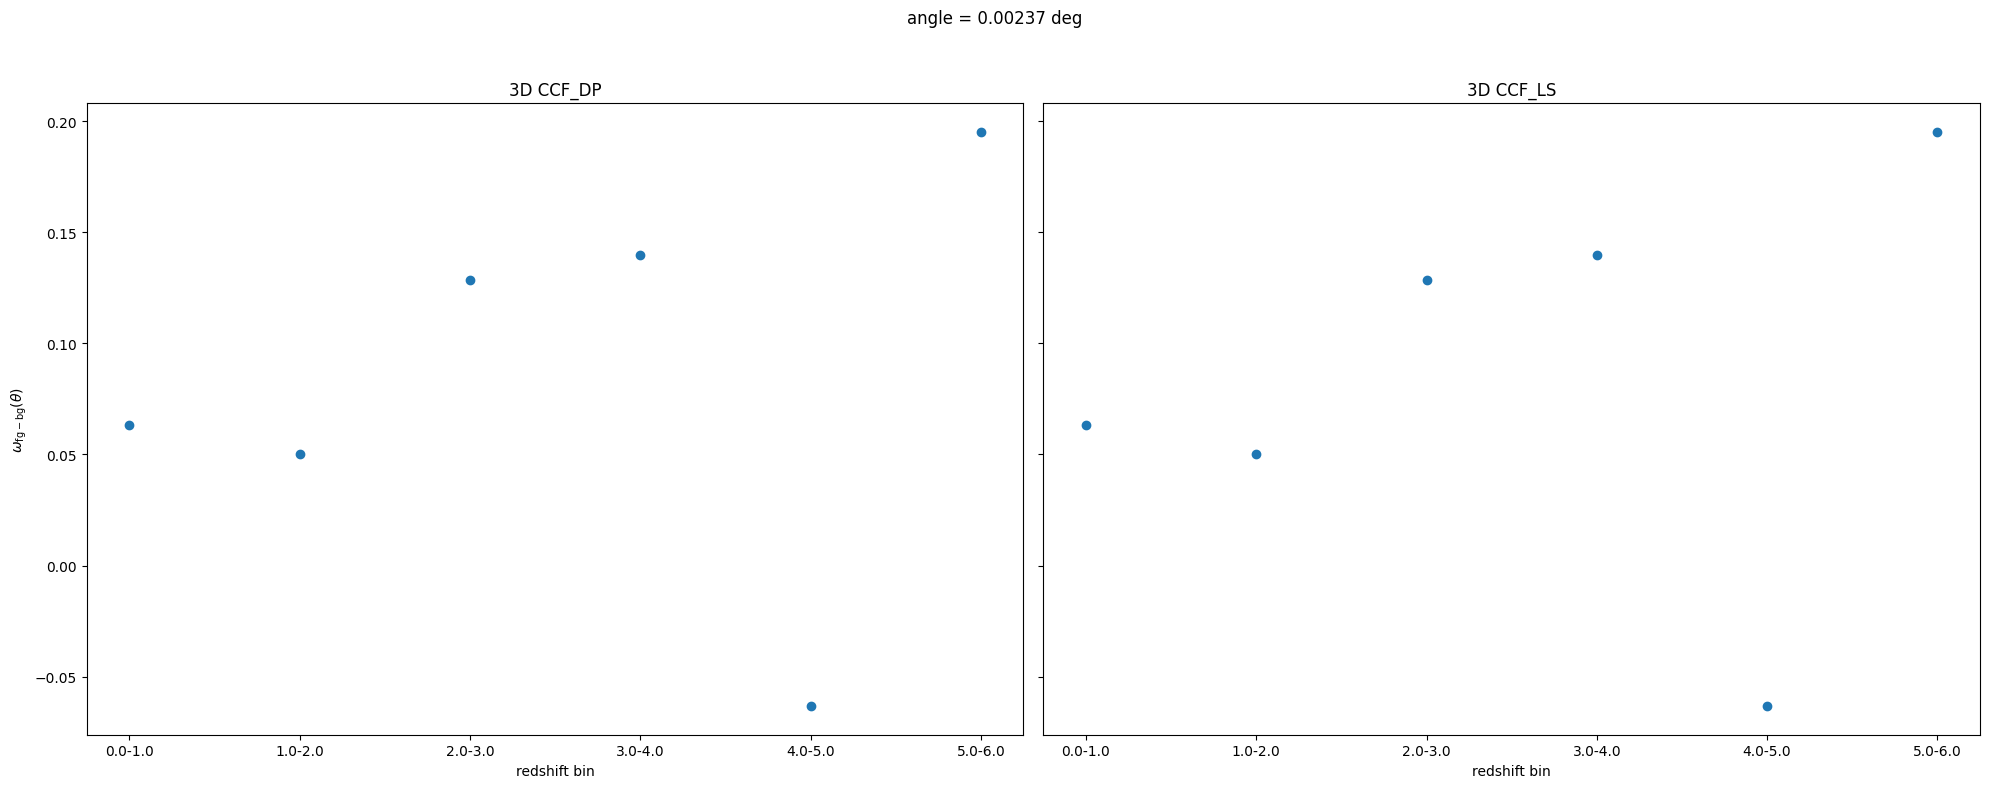

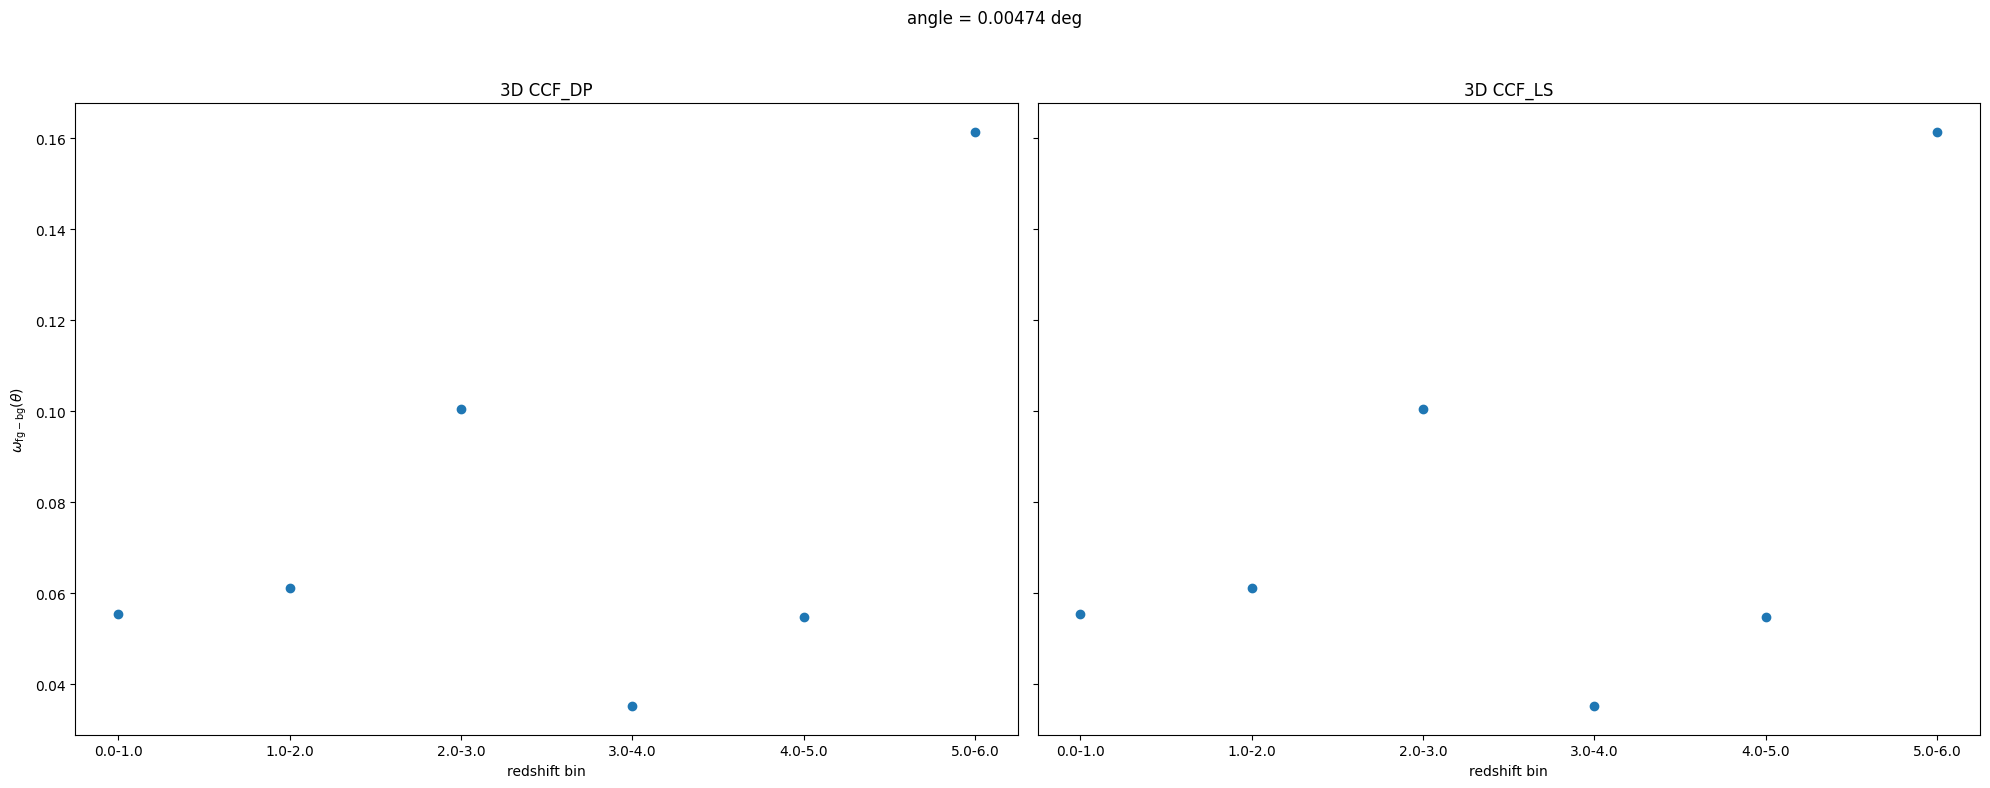

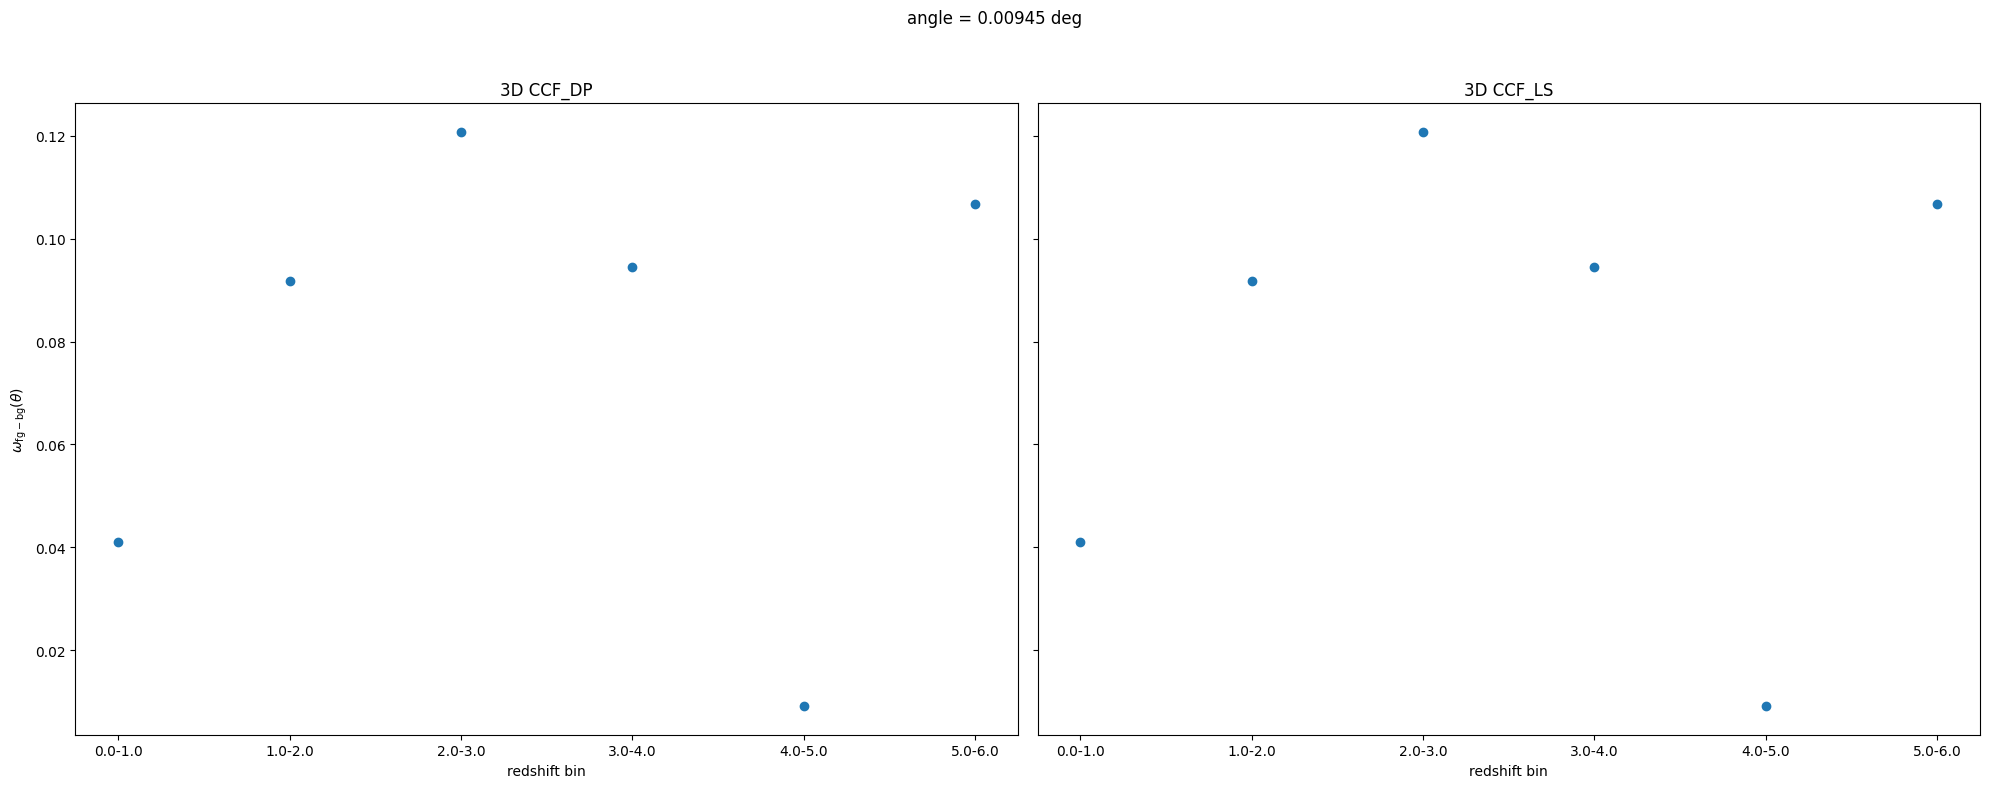

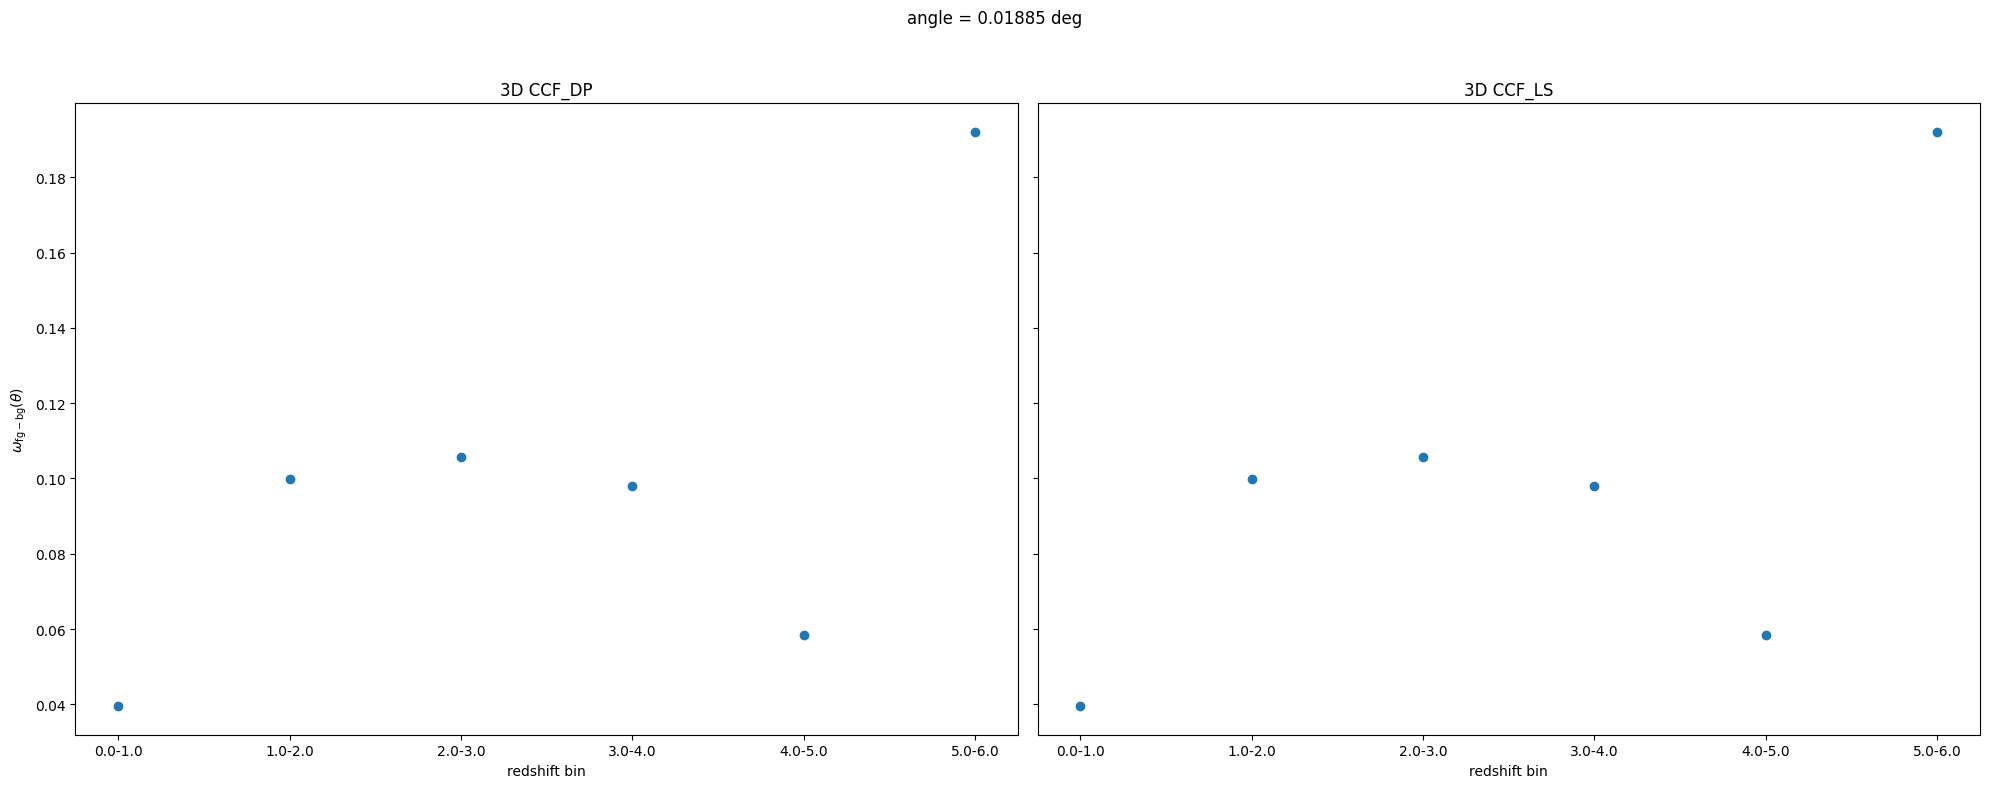

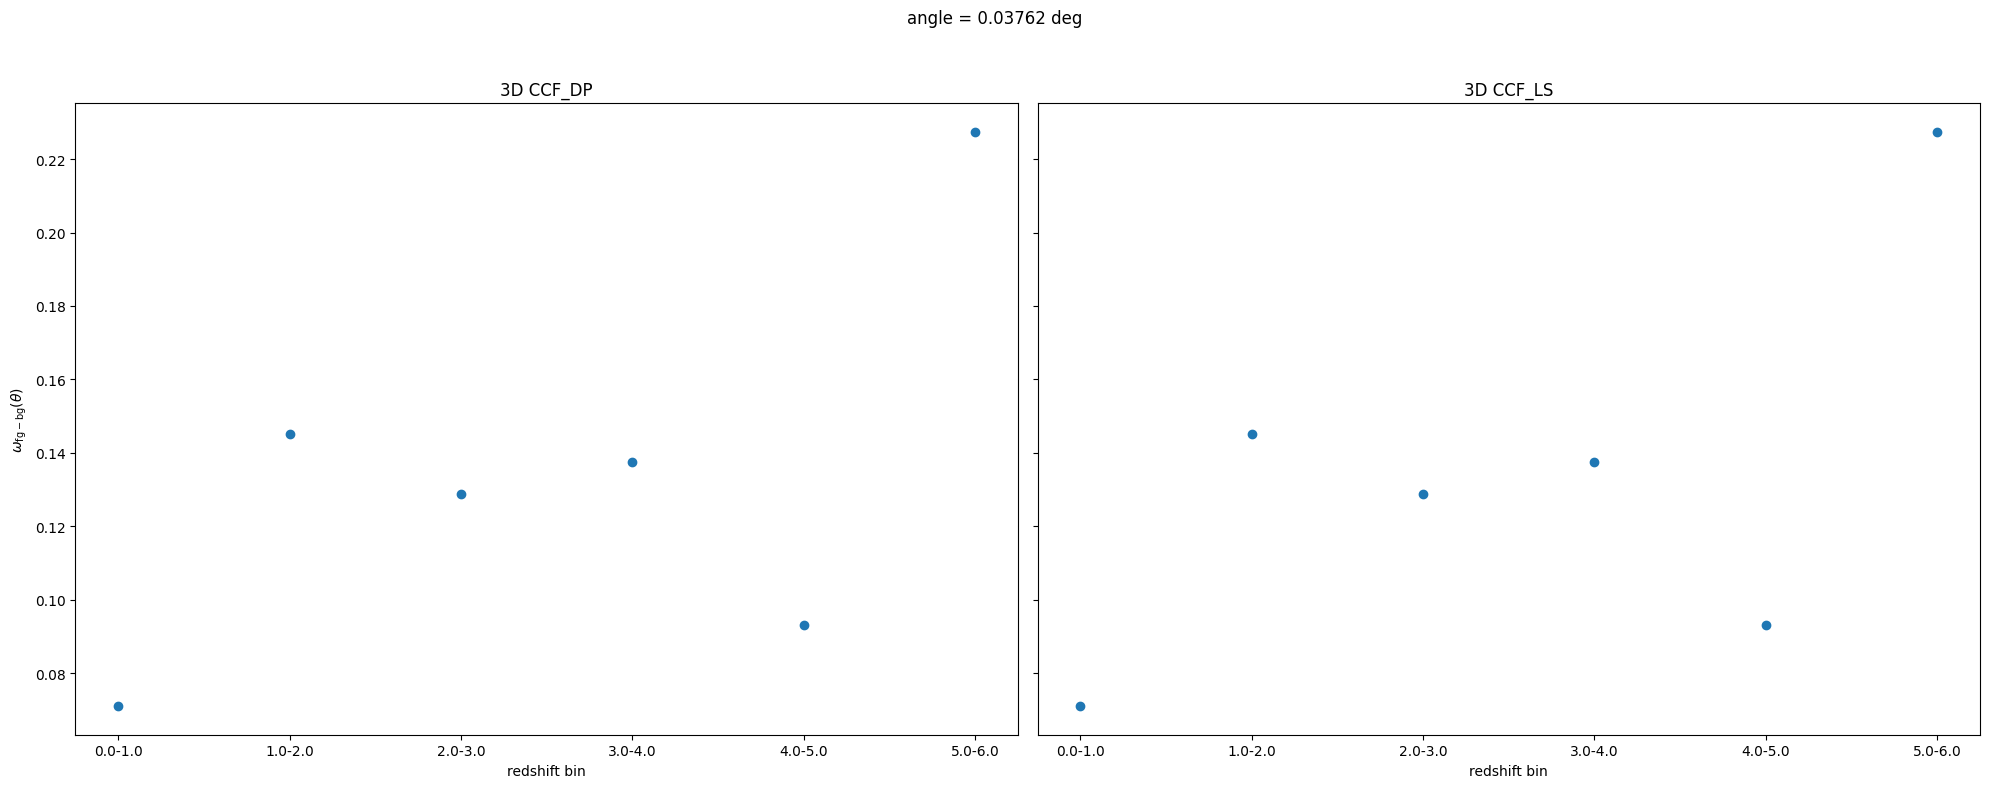

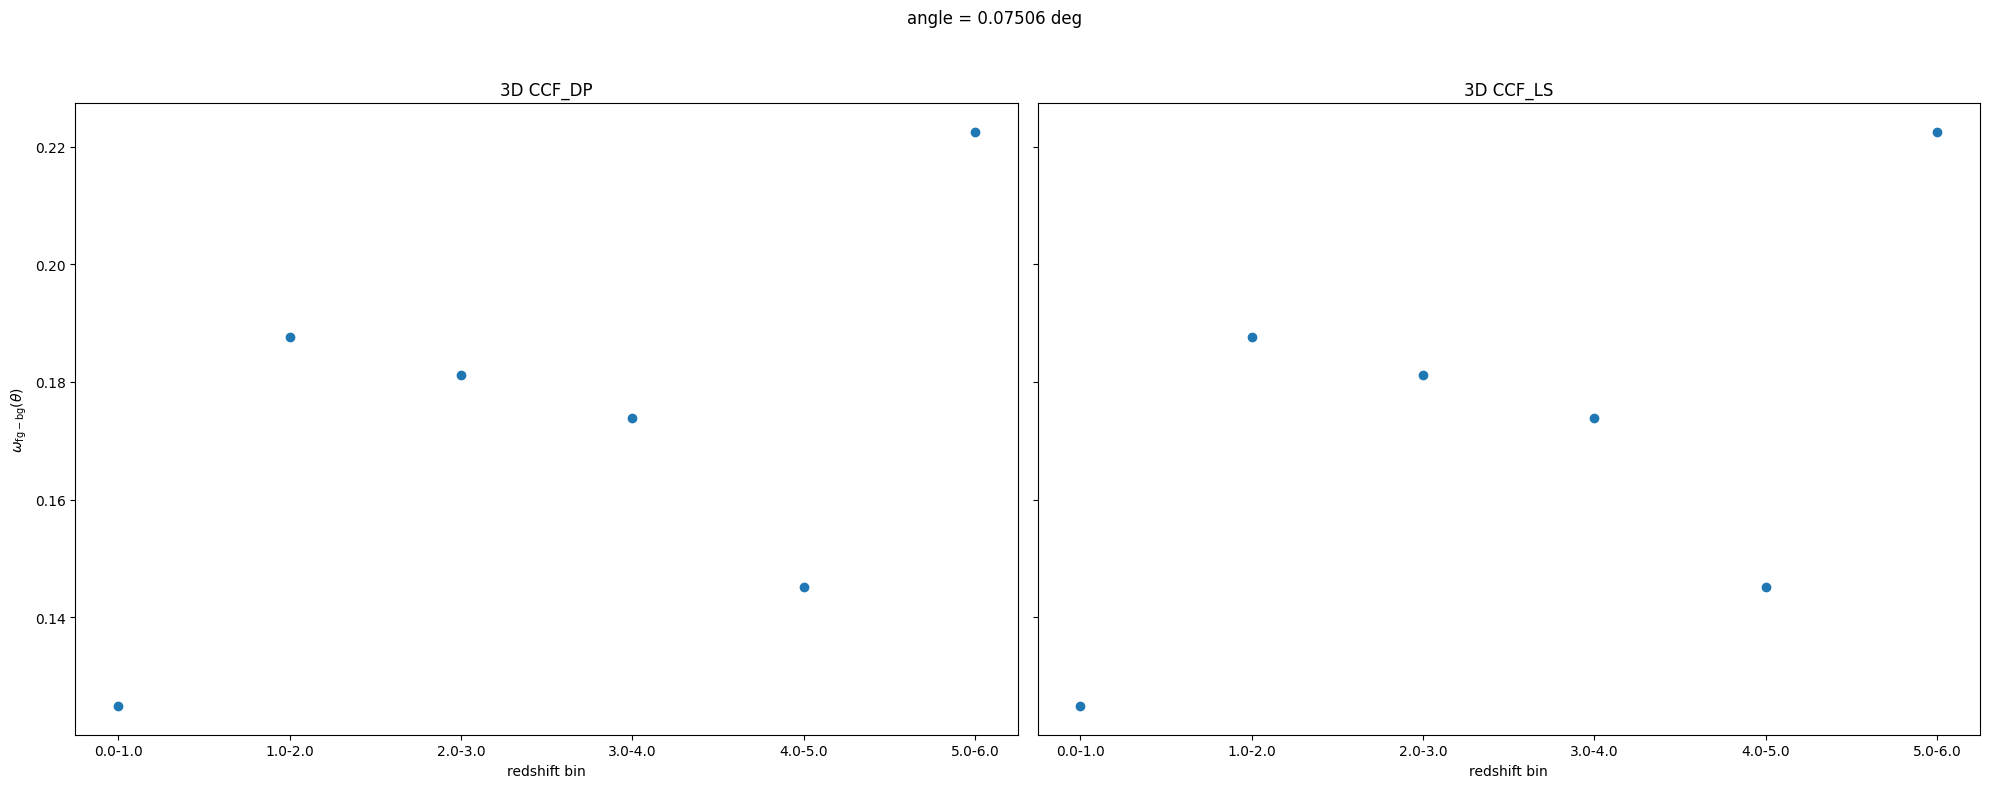

In [104]:
for j in range(len(values_3D_DP)):
    fig, axes = plt.subplots(1, 2, figsize=(20,8), sharey=True)
    fig.suptitle(f'angle = {angles[j]:.5f} deg')

    axes[0].set_title('3D CCF_DP')
    axes[0].set_xlabel('redshift bin')
    axes[0].set_ylabel(r'$\omega_{\rm fg-bg}(\theta)$')
    axes[0].scatter(z_bins, values_3D_DP[j])

    axes[1].set_title('3D CCF_LS')
    axes[1].set_xlabel('redshift bin')
    axes[1].scatter(z_bins, values_3D_LS[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

In [13]:
ncc = yaw.RedshiftData.from_corrfuncs(
    cross_corr=cts_sp,
    ref_corr=cts_ss,
    # unk_corr=None,
)

c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\paircounts.py:563: RuntimeWarning: invalid value encountered in divide
  data = _counts.data / _weights.data
c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\paircounts.py:564: RuntimeWarning: invalid value encountered in divide
  samples = _counts.samples / _weights.samples
c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\redshifts.py:290: RuntimeWarning: invalid value encountered in sqrt
  nz_data = w_sp_data / np.sqrt(dz2_data * w_ss_data * w_pp_data)
c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\redshifts.py:291: RuntimeWarning: invalid value encountered in sqrt
  nz_samples = w_sp_samp / np.sqrt(dz2_samples * w_ss_samp * w_pp_samp)


In [14]:
# ncc.data  # length num_bins
# ncc.error  # length num_bins
# ncc.samples  # shape (num_samples=num_patches, num_bins)
# ncc.covariance  # shape (num_bins, num_bins)

In [15]:
# Create a folder to store csv file
output_folder_csvfile = 'C:/Users/andre/MasterCode/Code/YAW_results/TEST'
os.makedirs(output_folder_csvfile, exist_ok=True)  # Creates the folder if it doesn't exist

file_name = os.path.join(output_folder_csvfile, 'TEST')
ncc.to_files(file_name)
    # data/error         ->  nz_estimate.dat
    # jackknife samples  ->  nz_estimate.smp
    # covariance         ->  nz_estimate.cov
# restored = yaw.RedshiftData.from_files("nz_estimate")

In [16]:
print(ncc.normalised().data)
print(ncc.normalised().error)

[nan nan 2.2 nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]


Text(0, 0.5, '?!?!?')

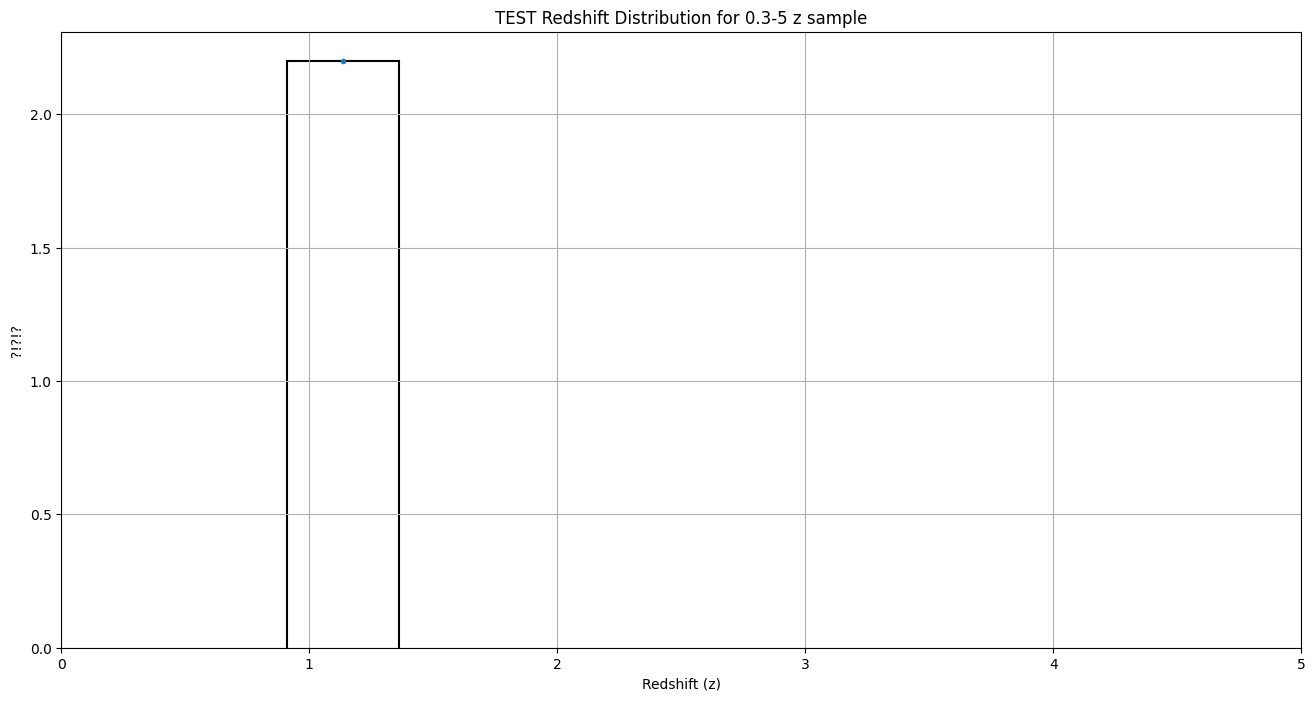

In [ ]:

plt.figure(figsize=(16,8))
plt.title('TEST Redshift Distribution for 0.3-5 z sample')
ncc.normalised().plot(style='point')
#ncc.normalised().plot(style='line')
ncc.normalised().plot(style='step')
plt.xlim(z_min_to_use,z_max_to_use)
plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('?!?!?')